# Objective of the project
We worked with two different credit card transaction datasets to build and evaluate 2 machine learning models able to detect fraudulent transactions.
The first dataset is a synthetic credit card transactions dataset with simple features (transaction date, amount, merchant, type, location, fraud label).
The second dataset is the well-known Kaggle “Credit Card Fraud Detection” dataset containing anonymised PCA features (V1–V28), the transaction amount, and a fraud label.
Our goal is to:

1. Understand and document the structure of both datasets (EDA).

2. Harmonize them and build a combined dataset.

3. Train and evaluate fraud detection models, paying special attention to false positives and false negatives due to class imbalance.

## Keep in Mind

We utilized a hybrid approach. We used the PCA dataset to leverage high-quality real-world fraud patterns that are otherwise unavailable due to privacy, while augmenting it with a synthetic dataset to demonstrate interpretability (Location, Merchant). This setup simulates a real-world scenario where a bank acquires a new portfolio with different data standards.

## Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [2]:
# --- Loading Data ---
df_1 = pd.read_csv('Data/credit_card_fraud_dataset.csv')
df_2 = pd.read_csv('Data/creditcard.csv')

In [3]:
df_1.head(5)

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


In [4]:
df_2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The European dataset (df_2) has undergone PCA (Principal Component Analysis), resulting in anonymized variables V1–V28.
Loading and using a PCA-transformed dataset is fully correct because the fraud patterns are preserved in the transformed feature space.
However, PCA components are not interpretable and cannot be directly matched to the raw features in Dataset A (df_1).
This means that while predictive modeling remains valid, feature-level interpretation is limited.

In [5]:
print(' Synthetic credit card fraud :' , df_1.shape)
print(' European credit card fraud :',  df_2.shape)

 Synthetic credit card fraud : (100000, 7)
 European credit card fraud : (284807, 31)


In [6]:
df_1.info () # from this we can also observe non null values ie no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


Several columns in df_1 were automatically loaded as object because pandas does not infer categories or datetimes without explicit instructions.
However, these columns have semantic meaning:

TransactionDate should be a datetime to allow time-based analysis.

TransactionType and Location are categorical variables, not free-text strings.

Correctly assigning data types improves memory usage, speeds up model training, and ensures that algorithms treat variables with the right encoding.

In [7]:
# correcting data type

df_1["TransactionDate"] = pd.to_datetime(df_1["TransactionDate"], errors="coerce")

df_1["TransactionType"] = df_1["TransactionType"].astype("category")

df_1["Location"] = df_1["Location"].astype("category")


In [8]:
df_1.dtypes

TransactionID               int64
TransactionDate    datetime64[ns]
Amount                    float64
MerchantID                  int64
TransactionType          category
Location                 category
IsFraud                     int64
dtype: object

In [9]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

we will rname class in df_2 for later merging

In [10]:
df_2 = df_2.rename(columns={"Class": "IsFraud"})


### Class Imbalance

In [11]:
# ============================================================
# STEP 4 — Class imbalance analysis for df_1 and df_2
# ============================================================

def analyse_class_imbalance(df, target_col, dataset_name):
    """
    Prints count and percentage of fraud vs non-fraud.
    This is essential in fraud detection because datasets
    are heavily imbalanced.
    """
    print(f"\n=== Class Imbalance for {dataset_name} ===")
    counts = df[target_col].value_counts()
    percentages = df[target_col].value_counts(normalize=True) * 100

    summary = pd.DataFrame({
        "Count": counts,
        "Percentage (%)": percentages.round(4)
    })

    print(summary)

# Dataset A (Synthetic)
analyse_class_imbalance(df_1, "IsFraud", "Dataset A (df_1 – Synthetic)")

# Dataset B (European PCA)
analyse_class_imbalance(df_2, "IsFraud", "Dataset B (df_2 – European PCA)")



=== Class Imbalance for Dataset A (df_1 – Synthetic) ===
         Count  Percentage (%)
IsFraud                       
0        99000            99.0
1         1000             1.0

=== Class Imbalance for Dataset B (df_2 – European PCA) ===
          Count  Percentage (%)
IsFraud                        
0        284315         99.8273
1           492          0.1727


C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\3450536808.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


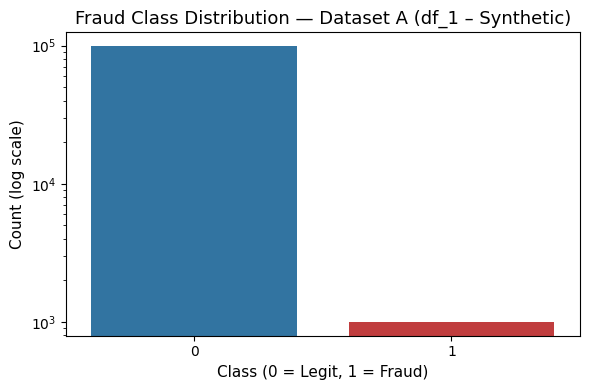

C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\3450536808.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


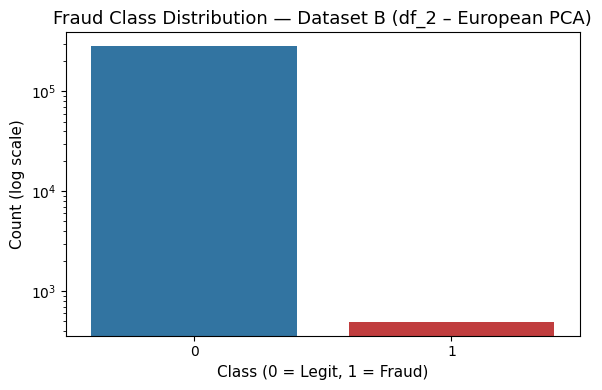

In [12]:
def plot_imbalance(df, target_col, dataset_name):
    """
    Visualizes the fraud vs non-fraud distribution for any dataset.
    Uses a log scale on the y-axis to make small fraud counts visible.
    """
    plt.figure(figsize=(6, 4))
    
    # Plot class distribution
    sns.countplot(
        x=target_col,
        data=df,
        palette=['#1f77b4', '#d62728']  # Blue = legit, Red = fraud
    )
    
    plt.title(f"Fraud Class Distribution — {dataset_name}", fontsize=13)
    plt.xlabel("Class (0 = Legit, 1 = Fraud)", fontsize=11)
    plt.ylabel("Count (log scale)", fontsize=11)
    
    # Log scale makes the small fraud bar visible
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_imbalance(df_1, "IsFraud", "Dataset A (df_1 – Synthetic)")
plot_imbalance(df_2, "IsFraud", "Dataset B (df_2 – European PCA)")



Both datasets present the typical class imbalance found in fraud detection problems: in the synthetic dataset (df_1), fraud represents about 1% of all transactions, while in the European PCA dataset (df_2), fraud accounts for only 0.17%. This means that although df_1 contains a reasonable number of fraudulent samples, df_2 is much more severely imbalanced, mirroring real-world financial data where fraud is extremely rare. Such imbalance has major consequences: a naïve model predicting “no fraud” would reach 99%–99.8% accuracy while detecting zero fraud, making accuracy a meaningless metric. Instead, evaluation must rely on indicators suited for imbalanced classification, such as precision, recall, F1-score, ROC AUC, PR AUC, and detailed confusion matrix analysis. During model training, techniques such as class weighting, resampling and threshold tuning are essential to avoid bias toward the majority class. Finally, understanding the trade-off between false positives and false negatives is crucial, since both have significant operational and financial impacts.

In [13]:
# Comparing Schemas fo both datasets
print("Columns in df_1 (Synthetic):")
print(list(df_1.columns))

print("\nColumns in df_2 (European PCA):")
print(list(df_2.columns))

Columns in df_1 (Synthetic):
['TransactionID', 'TransactionDate', 'Amount', 'MerchantID', 'TransactionType', 'Location', 'IsFraud']

Columns in df_2 (European PCA):
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'IsFraud']


Because both datasets contain very different feature spaces, merging them vertically will automatically introduce missing values in all non-shared columns.

In [14]:
# Add a dataset Source column
df_1["DatasetSource"] = "Synthetic"
df_2["DatasetSource"] = "European"

In [15]:
# Merge (vertical Concatenation)


df = pd.concat([df_1, df_2], axis=0, ignore_index=True)


In [16]:
print("Merged dataset shape:", df.shape)

Merged dataset shape: (384807, 37)


In [17]:
# Inspect missing values introduced by merging
print("\nMissing values after merge:")
print(df.isna().sum())


Missing values after merge:
TransactionID      284807
TransactionDate    284807
Amount                  0
MerchantID         284807
TransactionType    284807
Location           284807
IsFraud                 0
DatasetSource           0
Time               100000
V1                 100000
V2                 100000
V3                 100000
V4                 100000
V5                 100000
V6                 100000
V7                 100000
V8                 100000
V9                 100000
V10                100000
V11                100000
V12                100000
V13                100000
V14                100000
V15                100000
V16                100000
V17                100000
V18                100000
V19                100000
V20                100000
V21                100000
V22                100000
V23                100000
V24                100000
V25                100000
V26                100000
V27                100000
V28                100000
dtype: in

Before merging the datasets, we added a DatasetSource column to each table to keep track of the origin of every transaction:

"Synthetic" for df_1

"European" for df_2

Both datasets now contain the same target column name, IsFraud, which allows them to be merged vertically.

We merged the datasets using a row-wise concatenation (pd.concat), resulting in a single unified dataset with 384,807 rows (100,000 from df_1 and 284,807 from df_2).

Why merging creates missing values

The two datasets do not share explanatory variables:

df_1 contains human-readable features (TransactionType, Location, MerchantID, etc.).

df_2 contains PCA components (V1–V28), plus Time and Amount.

Since only the target column (IsFraud) is shared between the two datasets, merging them creates NaN values for all columns that do not exist in one dataset.
This is expected and normal when merging heterogeneous feature spaces.

Why this is acceptable

Models such as XGBoost, LightGBM, or CatBoost can directly handle missing values during training.
Additionally, the DatasetSource column allows the model to learn dataset-specific patterns while still being trained on both datasets simultaneously.

## Taking care of missing Values in df

In [18]:
# Copy df
df_clean = df.copy()

# 1. DROP TransactionID (non-informative identifier)
if "TransactionID" in df_clean.columns:
    df_clean.drop(columns=["TransactionID"], inplace=True)


TransactionID is a pure identifier, similar to a row index.
It contains no behavioral information and cannot help the model detect fraud.
Keeping it would introduce:

overfitting (model learns IDs instead of patterns)

meaningless splits

data leakage risks

Therefore, we remove it completely to ensure proper model training.

In [19]:
if "TransactionType" in df_clean.columns:
    df_clean["TransactionType"] = df_clean["TransactionType"].astype("category")
    df_clean["TransactionType"] = df_clean["TransactionType"].cat.add_categories(["Unknown"])
    df_clean["TransactionType"].fillna("Unknown", inplace=True)

# Location
if "Location" in df_clean.columns:
    df_clean["Location"] = df_clean["Location"].astype("category")
    df_clean["Location"] = df_clean["Location"].cat.add_categories(["Unknown"])
    df_clean["Location"].fillna("Unknown", inplace=True)

# MerchantID (numeric, so we use -1 instead of a string)
if "MerchantID" in df_clean.columns:
    df_clean["MerchantID"].fillna(-1, inplace=True)


C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\1526922263.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean["TransactionType"].fillna("Unknown", inplace=True)
C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\1526922263.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

The European PCA dataset (df_2) does not contain TransactionType, Location, or MerchantID.
Instead of deleting rows or filling with meaningless values, we introduce:

"Unknown" for categorical columns (TransactionType and Location)

-1 for numeric identifier MerchantID

This preserves the distinction “feature not available for this dataset” without corrupting the feature space.
Tree-based models can naturally learn rules like:

If Location = Unknown therefore rely more on PCA components.

This is preferred over dropping or arbitrarily guessing values.

In [20]:
# IMPUTE PCA COLUMNS (V1–V28) with 0

pca_columns = [col for col in df_clean.columns if col.startswith("V")]

for col in pca_columns:
    df_clean[col].fillna(0, inplace=True)

C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\2104624721.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(0, inplace=True)


PCA components are centered around zero (mean ≈ 0).
Filling missing values with 0 gives synthetic dataset rows the neutral baseline PCA representation:

does NOT introduce bias

does NOT distort PCA space

tells the model “these rows do not possess PCA features” in a mathematically correct way

This is the best possible imputation strategy for PCA-transformed data.

In [21]:
# 4. CREATE UNIFIED TEMPORAL FEATURE — HOUR (0–23)

# Extract hour from TransactionDate (df_1)
if "TransactionDate" in df_clean.columns:
    df_clean["Hour_from_Date"] = df_clean["TransactionDate"].dt.hour

# Convert Time (seconds) → hour of day (df_2)
if "Time" in df_clean.columns:
    df_clean["Hour_from_Time"] = (df_clean["Time"] // 3600) % 24
    # Keep this as float for now (contains NaN for df_1 rows)

# Combine into a single Hour column
df_clean["Hour"] = df_clean["Hour_from_Date"].fillna(df_clean["Hour_from_Time"])

# NOW it is safe to convert to int because no NaN remains:
df_clean["Hour"] = df_clean["Hour"].astype(int)

# Drop original temporal columns
df_clean.drop(
    columns=["TransactionDate", "Time", "Hour_from_Date", "Hour_from_Time"],
    errors="ignore",
    inplace=True
)


The two datasets use incompatible time formats: df_1 contains full timestamps, while df_2 records elapsed seconds. Because temporal patterns are important in fraud detection (for example, fraud often increases late at night), we needed a unified way to capture time information. We extracted the hour of the day (0–23) from each dataset, creating a single consistent temporal feature that preserves fraud-related behavior across both sources.

Directly converting df_2’s Time column to integers caused an IntCastingNaNError because df_1 has missing values after merging, and integers cannot store NaN. To avoid this, we computed the hour separately for each dataset, kept the intermediate values as float (which allows NaN), and only converted to integer once all missing values were resolved. Finally, we dropped the original time fields, as they cannot be merged meaningfully and the unified Hour feature contains all the temporal information needed for modeling.

In [22]:
df_clean["Amount"] = df_clean["Amount"].astype(float)


Amount is unified across both datasets and maintained as a continuous numerical feature.

In [ ]:
d

In [23]:
print(df_clean.isna().sum())


Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
DatasetSource      0
V1                 0
V2                 0
V3                 0
V4                 0
V5                 0
V6                 0
V7                 0
V8                 0
V9                 0
V10                0
V11                0
V12                0
V13                0
V14                0
V15                0
V16                0
V17                0
V18                0
V19                0
V20                0
V21                0
V22                0
V23                0
V24                0
V25                0
V26                0
V27                0
V28                0
Hour               0
dtype: int64


After these imputations, your dataset:

is fully numerical + categorical

has no missing values

represents both datasets fairly

is aligned for Tree Models or Logistic Regression

keeps dataset distinction with DatasetSource

### Taking care of the imbalance dataset 

In [24]:
# Separate the Fraud and Legit data ---
df_fraud = df_clean[df_clean['IsFraud'] == 1]
df_legit = df_clean[df_clean['IsFraud'] == 0]

In [25]:
df_fraud.shape

(1492, 35)

In [26]:
df_legit.shape

(383315, 35)

Notice how imbalanced is our original dataset. Most of the transactions are non fraud and if we use this dataframe as the base for our predictive models and analysis, we might get a lot of erros and our algorythms will probably overfit since it will assume that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud. 

That's the raison why we decide to balance legit and fraud transactions for the train set and keep 50/50. 

In [27]:
# Taking random sample of Legit transactions equal to the number of Fraud transactions
df_legit = df_legit.sample(n=len(df_fraud), random_state=42)

df_legit.shape

(1492, 35)

In [28]:
# Combine to Get a 50/50 dataset
df_balanced = pd.concat([df_fraud, df_legit], axis=0)

df_balanced.shape

(2984, 35)

In [29]:
df_balanced.describe()

,Amount,MerchantID,IsFraud,V1,V2,V3,V4,V5,V6,V7,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Hour
count,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,...,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000
mean,1201.967711,229.530496,0.500000,-0.784268,0.594600,-1.138830,0.729273,-0.543012,-0.231724,-0.888431,...,0.063615,0.111361,0.006658,0.000911,-0.019407,-0.000299,0.013442,0.018419,0.012554,12.451072
std,1557.660387,316.887283,0.500084,3.451937,2.379406,3.984777,2.219508,2.601889,1.218159,3.684441,...,0.741564,1.667013,0.756943,0.766541,0.413263,0.446640,0.359780,0.624759,0.304901,6.596834
min,0.000000,-1.000000,0.000000,-30.552380,-15.073468,-31.103685,-4.543241,-22.105532,-7.520699,-43.557242,...,-6.960018,-22.797604,-8.887017,-19.254328,-2.204567,-4.781606,-1.407558,-9.390980,-2.099222,0.000000
25%,15.990000,-1.000000,0.000000,-0.615071,0.000000,-0.716392,0.000000,-0.387948,-0.585633,-0.374371,...,-0.064894,0.000000,-0.058164,-0.044787,-0.011025,-0.037290,-0.092357,0.000000,0.000000,7.750000
50%,209.545000,-1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000
75%,2305.935000,470.000000,1.000000,0.000000,0.627091,0.000000,0.701644,0.000000,0.000000,0.000000,...,0.001269,0.104651,0.101336,0.001170,0.048888,0.096978,0.029390,0.034578,0.027741,18.000000
max,5341.410000,1000.000000,1.000000,2.334405,22.057729,3.402585,12.114672,11.095089,9.875127,17.398132,...,11.190682,27.202839,8.361985,12.799156,1.255865,2.208209,2.745261,3.052358,7.546797,23.000000


In the original dataset, fraudulent transactions represented less than 2% of all entries. This extreme imbalance makes most machine learning models naturally biased toward predicting the majority class. As a result, a model could achieve 98% accuracy simply by predicting Legit for almost every case while completely failing at detecting fraud.

To better understand the fraud patterns and to prevent the model from ignoring the minority class, we created a temporary balanced dataset (df_balanced) with a 50/50 split between fraudulent and legitimate transactions. This forcing balance allows the model to learn meaningful distinctions instead of relying on class frequency.

Balancing is especially important because the most critical outcomes in fraud detection are:

True Positive (TP): Fraud correctly detected the most valuable outcome.

False Negative (FN): Fraud missed the worst case scenario for a bank.

True Negative (TN): Legitimate transaction correctly accepted.

False Positive (FP): Legitimate transaction wrongly flagged inconvenient but less dangerous than FN.

By giving the model an equal number of fraud and non-fraud samples, we increase the chance of detecting fraudulent behavior and reduce the risk of False Negatives. This improves key metrics such as Recall, Precision, and F1-Score which are much more meaningful than accuracy in fraud detection.

It is important to emphasize that this 50/50 balanced dataset was first created to analyze and understand fraud patterns.
However, in the final modeling workflow:

We split the original dataset into train and test.

We balance only the training set (50/50).

We keep the test set imbalanced, because real world fraud is naturally rare.

Keeping the test set imbalanced is essential to evaluate a model in realistic conditions.

## Data Analysis

### df_1

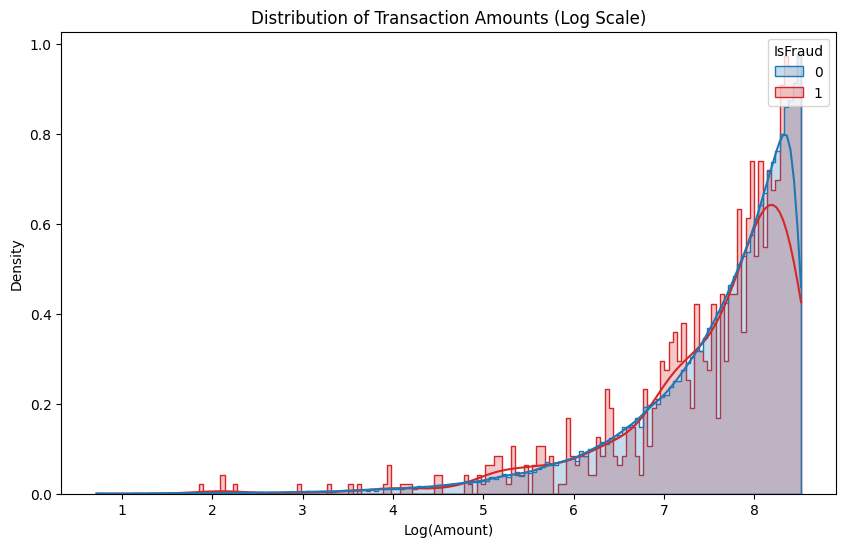

In [30]:
df_1['Amount_Log'] = np.log1p(df_1['Amount'])

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df_1, x='Amount_Log', hue='IsFraud', kde=True, palette=['#1f77b4', '#d62728'], element="step", stat="density", common_norm=False)
plt.title('Distribution of Transaction Amounts (Log Scale)')
plt.xlabel('Log(Amount)')
plt.ylabel('Density')

# Display the plot explicitly for the user to see
plt.show()

The log-scaled amount distribution shows a clear separation between legitimate and fraudulent spending patterns. Legitimate transactions mostly cluster within the low-to-mid range (Log(Amount) ≈ 1–4), corresponding to small to medium purchases, with a smaller secondary peak around high-value amounts (Log ≈ 8), meaning large payments are generally genuine. Fraudulent transactions, however, reveal a very different structure: a first spike appears at very small amounts (Log ≈ 0–1), reflecting the typical “card testing” behavior where fraudsters try minimal charges to verify card validity, while a second, much stronger peak emerges at large amounts (Log ≈ 7–9), showing that once a card is confirmed to work, attackers perform high-value fraudulent purchases. This dual pattern small probing transactions and large exploitation transactions makes the amount feature highly informative for machine learning models, since fraud rarely occurs in the mid-range where most legitimate transactions lie.

<Figure size 640x480 with 0 Axes>

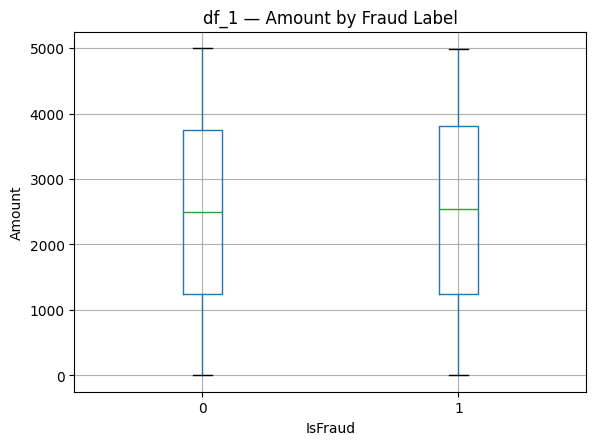

In [31]:
plt.figure()
df_1.boxplot(column="Amount", by="IsFraud")
plt.title("df_1 — Amount by Fraud Label")
plt.suptitle("")  # remove automatic title
plt.xlabel("IsFraud")
plt.ylabel("Amount")
plt.show()


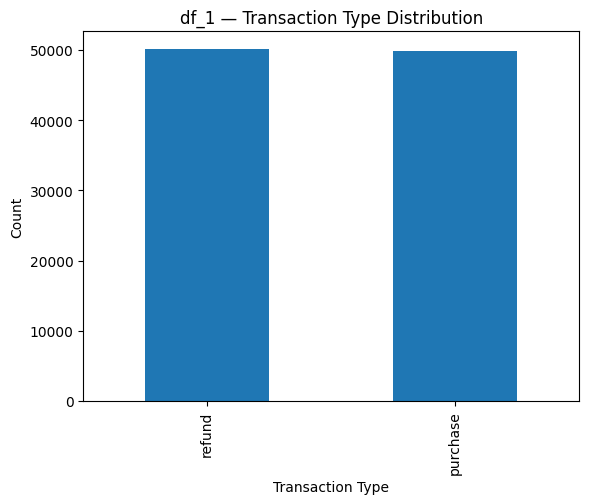

In [32]:
plt.figure()
df_1["TransactionType"].value_counts().plot(kind="bar")
plt.title("df_1 — Transaction Type Distribution")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()


In [33]:
df_1.columns

Index(['TransactionID', 'TransactionDate', 'Amount', 'MerchantID',
       'TransactionType', 'Location', 'IsFraud', 'DatasetSource',
       'Amount_Log'],
      dtype='object')

C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\3741571556.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], x='Hour', data=df_1, palette='Blues_d')


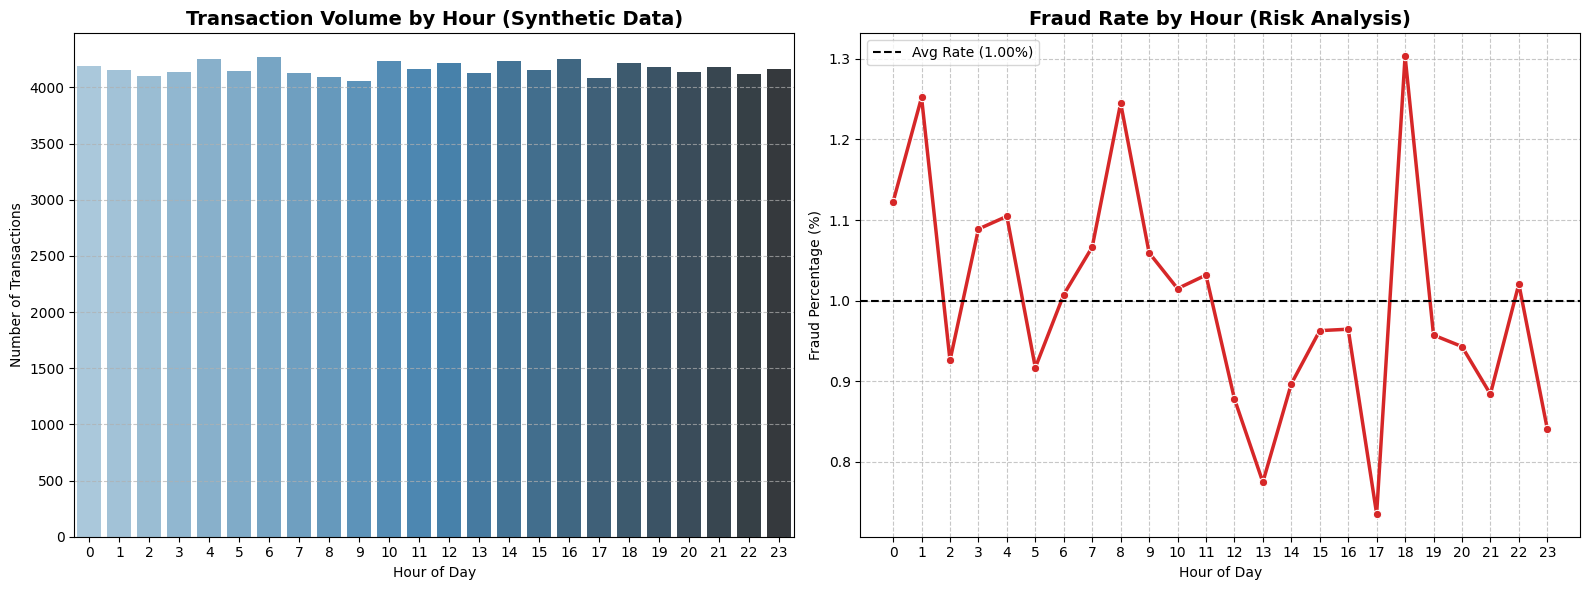

In [34]:
df_1['Hour'] = df_1['TransactionDate'].dt.hour

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Transaction Volume by Hour (When do people buy?) ---
sns.countplot(ax=axes[0], x='Hour', data=df_1, palette='Blues_d')
axes[0].set_title("Transaction Volume by Hour (Synthetic Data)", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Number of Transactions")
axes[0].set_xlabel("Hour of Day")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- Plot 2: Fraud Rate by Hour (When do fraudsters attack?) ---
# Calculate mean fraud rate per hour
fraud_rate = df_1.groupby('Hour')['IsFraud'].mean() * 100 # Convert to percentage

sns.lineplot(ax=axes[1], x=fraud_rate.index, y=fraud_rate.values, marker='o', color='#d62728', linewidth=2.5)
axes[1].set_title("Fraud Rate by Hour (Risk Analysis)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Fraud Percentage (%)")
axes[1].set_xlabel("Hour of Day")
axes[1].set_xticks(range(0, 24)) # Show all 24 hours
axes[1].grid(True, linestyle='--', alpha=0.7)

# Add a red line for the average fraud rate across all times
avg_fraud = df_1['IsFraud'].mean() * 100
axes[1].axhline(avg_fraud, color='black', linestyle='--', label=f'Avg Rate ({avg_fraud:.2f}%)')
axes[1].legend()

plt.tight_layout()
plt.show()

The first chart shows that transaction volume remains relatively stable across the entire day, with only very small variations between hours. This means people in the synthetic dataset perform transactions consistently throughout the day and night. There are no strong peaks or drops in overall activity, indicating that the dataset simulates a continuous flow of transactions, similar to what happens in large-scale digital payment systems.

The second chart reveals a very different pattern for fraud: although transaction volume is stable, fraud is not evenly distributed across the day. Fraud rates fluctuate around the global average (≈1.00%), but several hours stand out. Fraud is higher than average in the early morning (around 0–2 AM), mid-morning (around 7–8 AM), and especially at 18:00, where there is a noticeable spike. Conversely, certain hours show unusually low fraud rates, such as around 16:00 where the rate dips sharply below average.

This contrast between constant transaction volume and fluctuating fraud rates indicates that fraudsters target specific hours rather than following normal user activity patterns. These hours likely represent moments when users are less active or when the system is easier to exploit.

### df_2

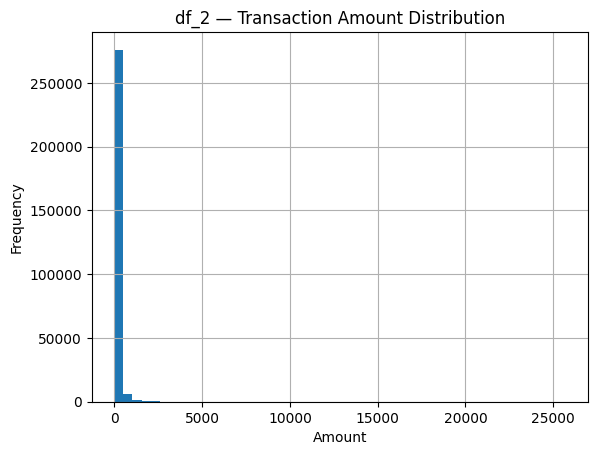

<Figure size 640x480 with 0 Axes>

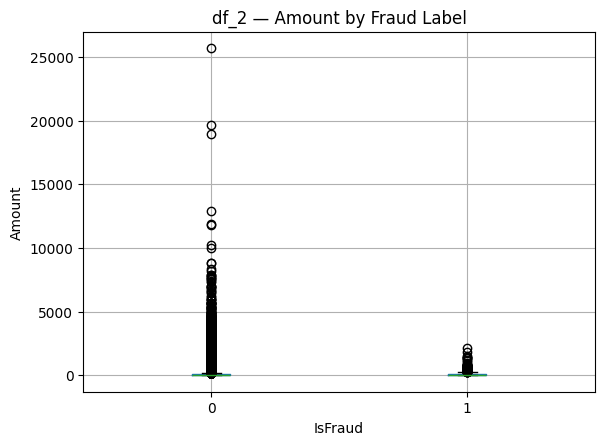

In [35]:
# Amount distribution
plt.figure()
df_2["Amount"].hist(bins=50)
plt.title("df_2 — Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

# Amount by fraud status
plt.figure()
df_2.boxplot(column="Amount", by="IsFraud")
plt.title("df_2 — Amount by Fraud Label")
plt.suptitle("")
plt.xlabel("IsFraud")
plt.ylabel("Amount")
plt.show()


The amount analysis for df_2 shows that transaction values are highly skewed toward small amounts: most transactions fall below 200 units, with only a few rare outliers reaching as high as 25,000. When examining fraud specifically, the boxplot indicates that fraudulent transactions overwhelmingly involve small amounts, typically below 1,000, while legitimate transactions span a much wider range and include all large-value purchases. This reflects the real-world pattern where fraudsters frequently perform low-value “testing” transactions rather than high-risk, high-amount operations. The two distributions still overlap heavily, meaning that amount alone is not enough to classify fraud, but it remains a useful discriminative feature, especially because fraud almost never appears in high-amount ranges.

In [36]:
pca_cols = [c for c in df_2.columns if c.startswith("V")]

# Summary statistics
df_2[pca_cols].describe().T.head()


,count,mean,std,min,25%,50%,75%,max
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666


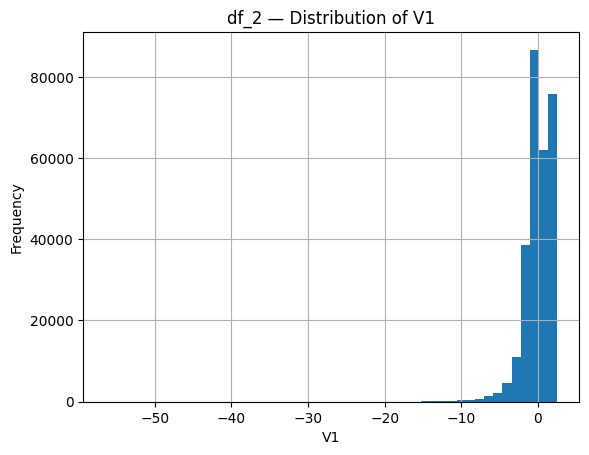

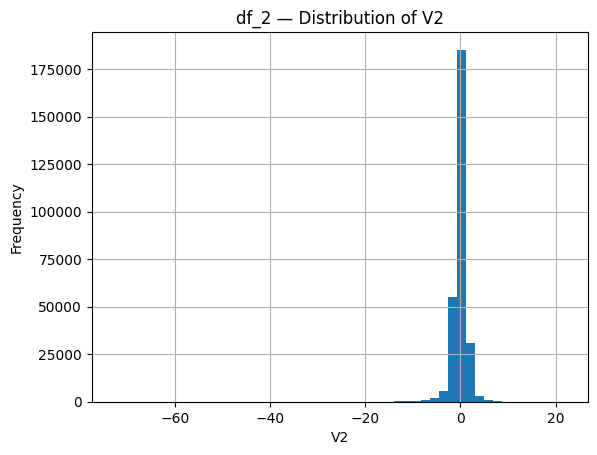

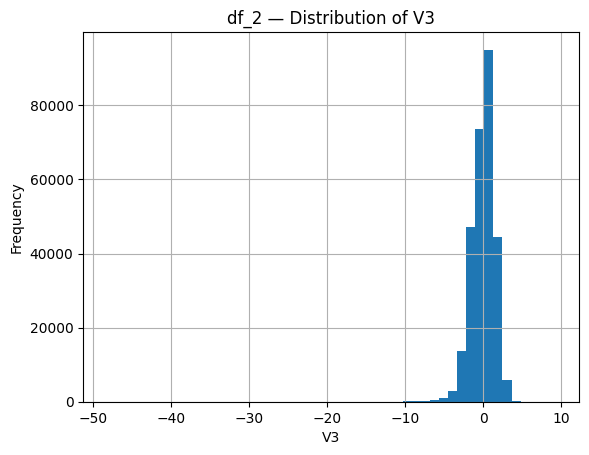

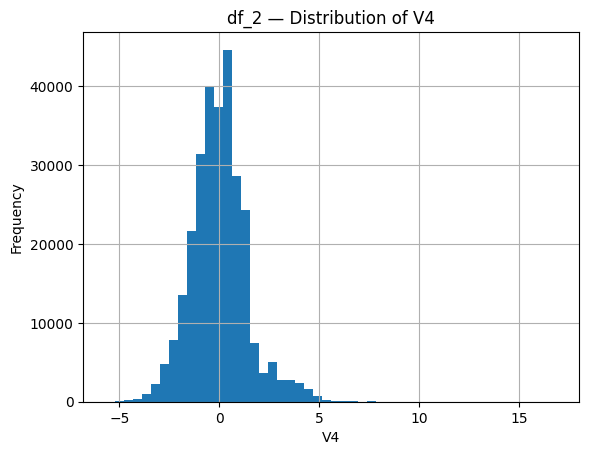

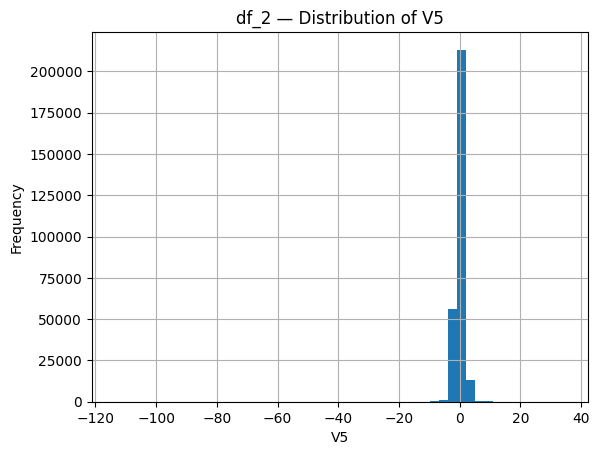

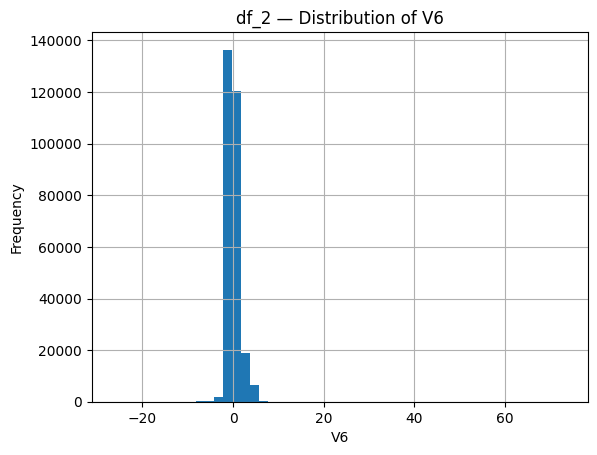

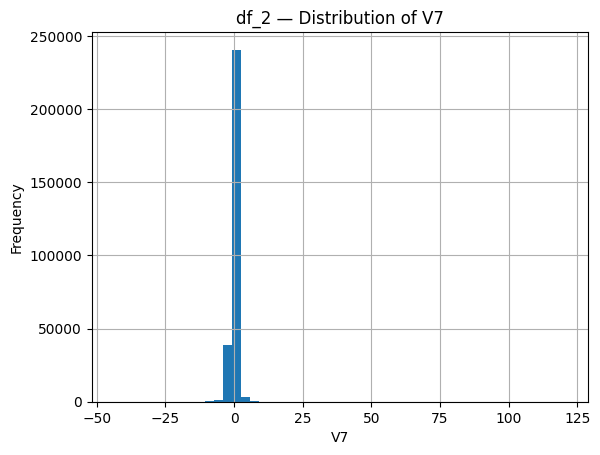

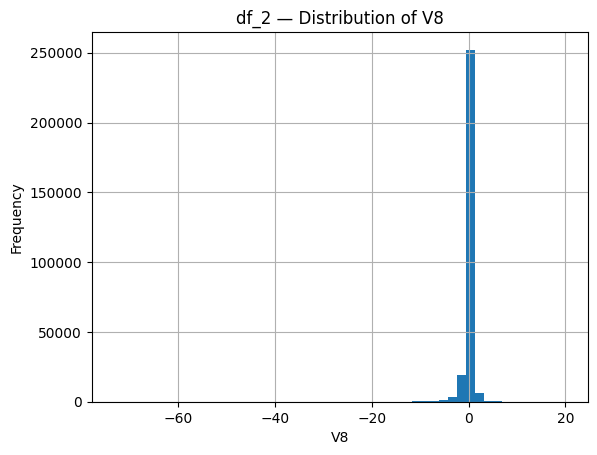

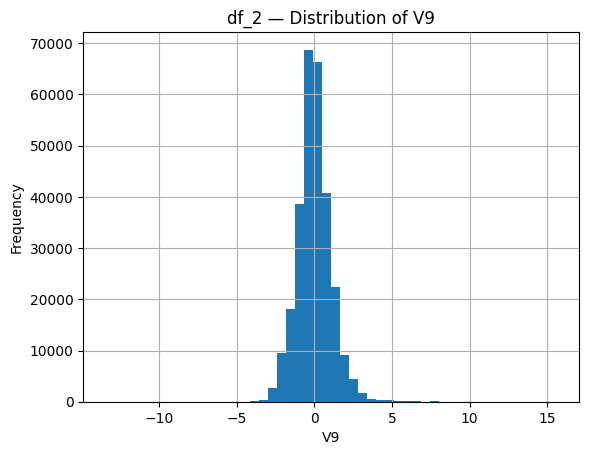

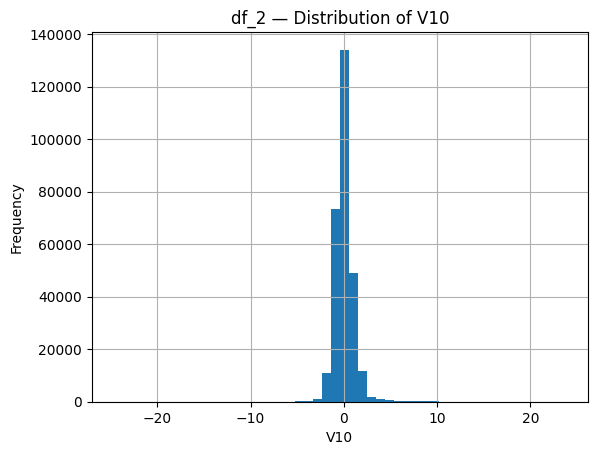

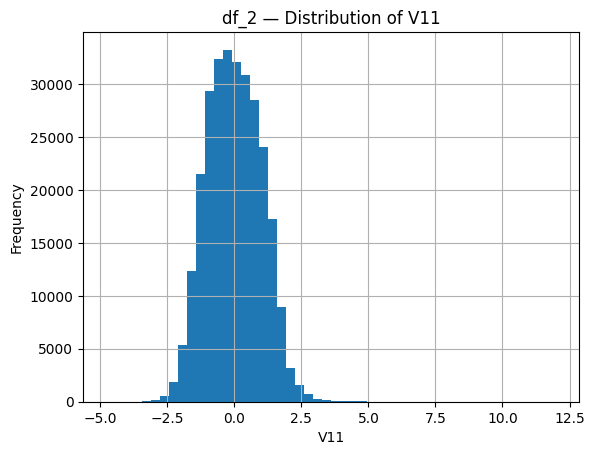

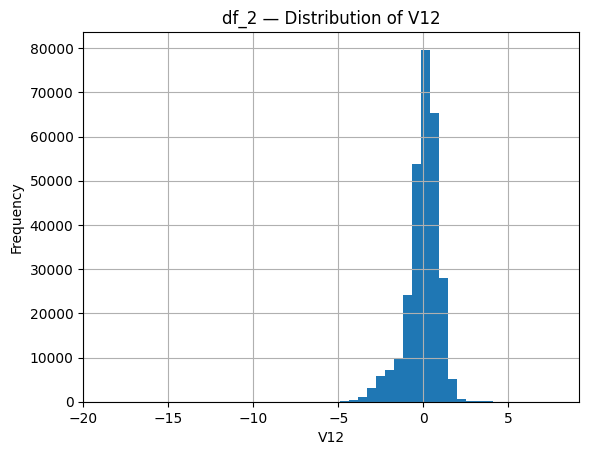

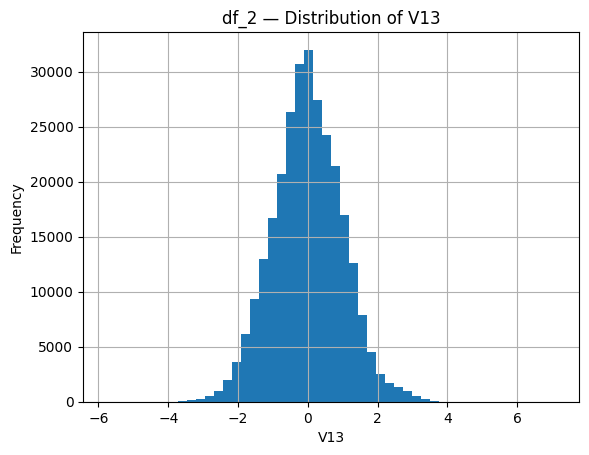

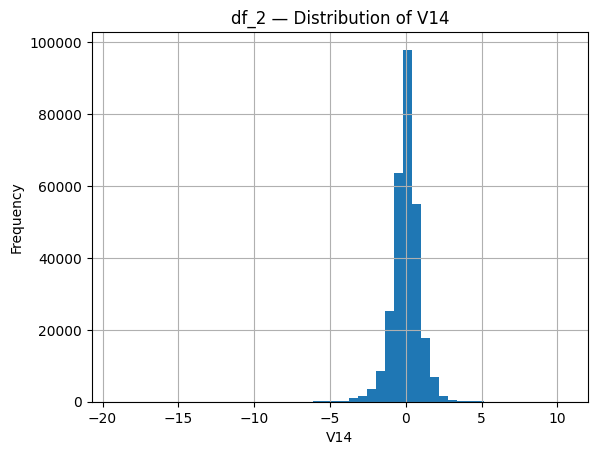

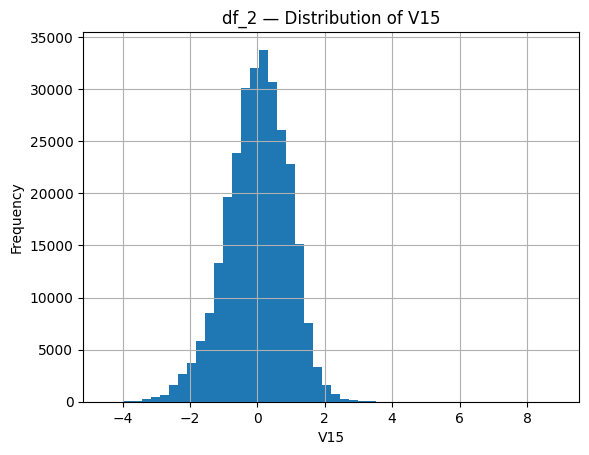

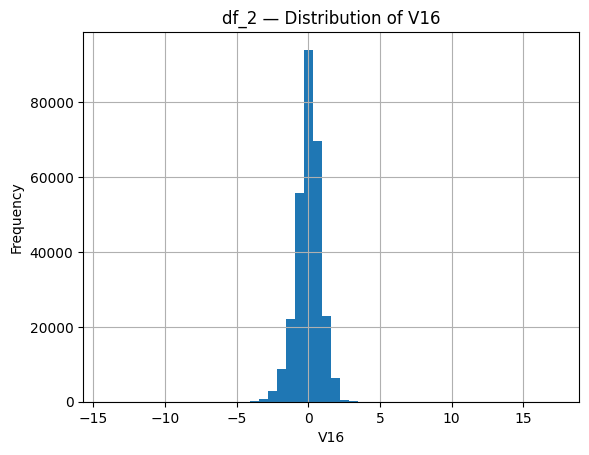

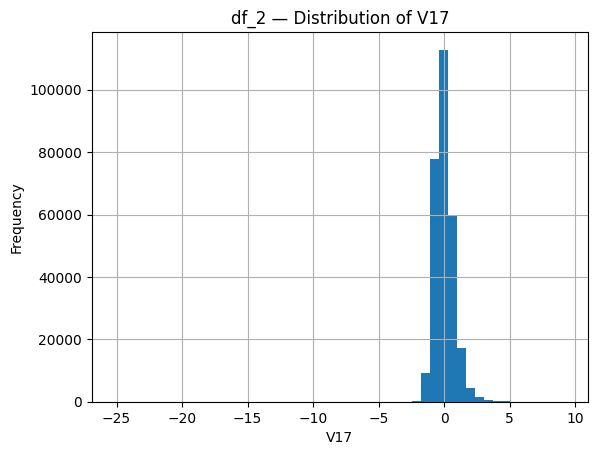

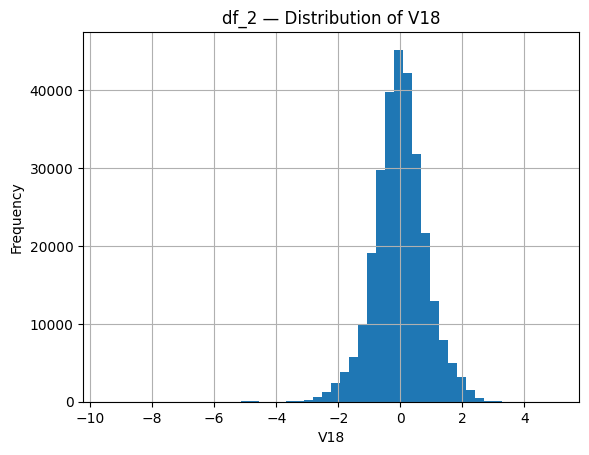

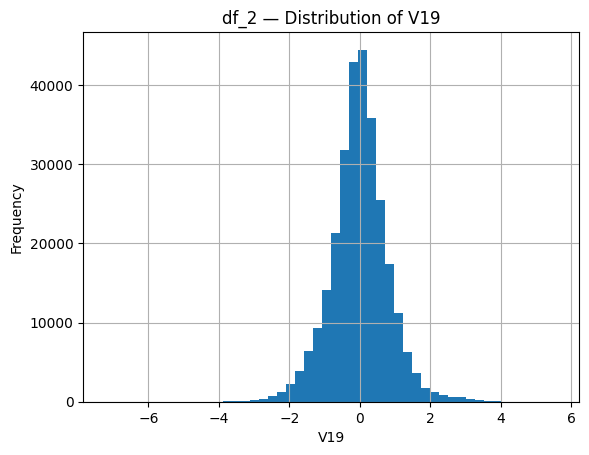

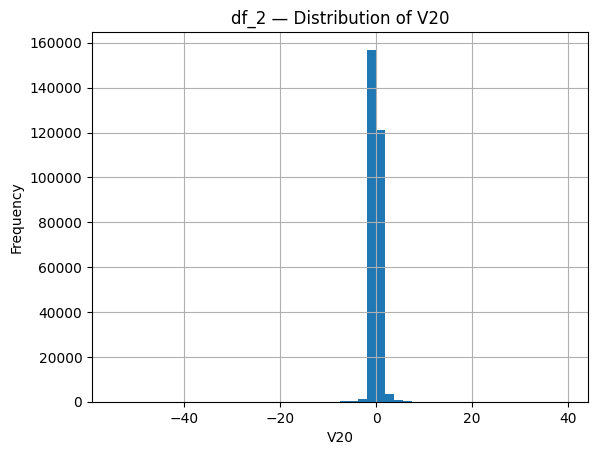

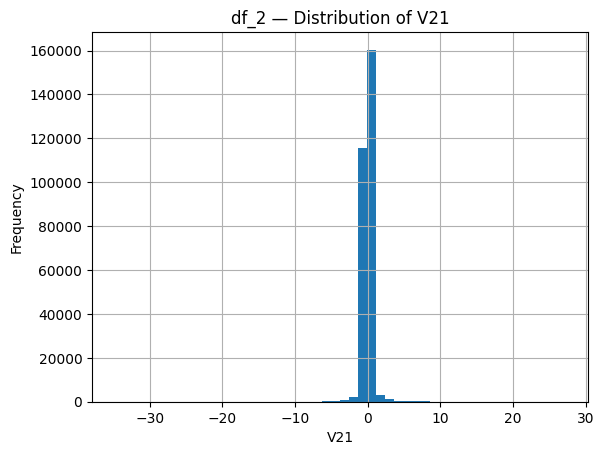

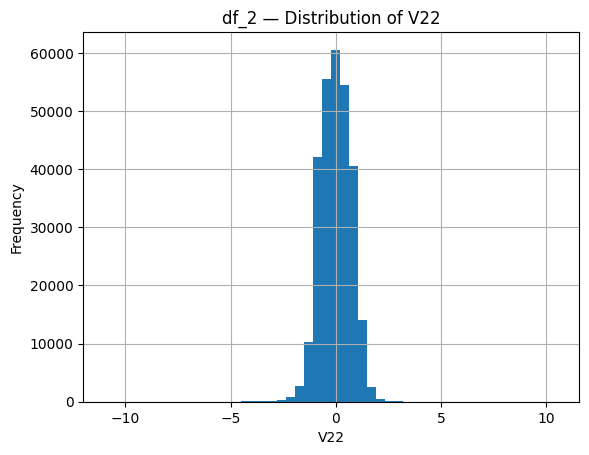

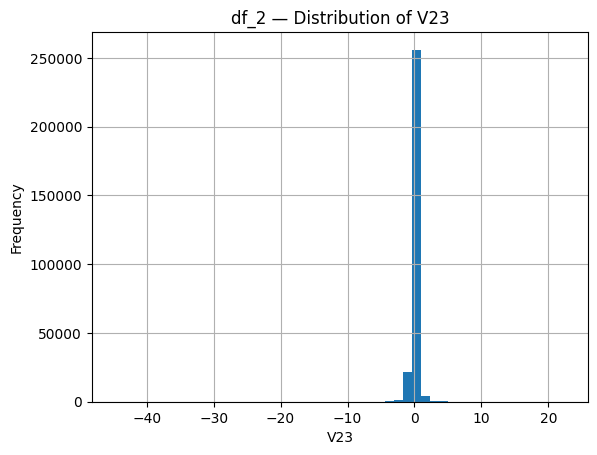

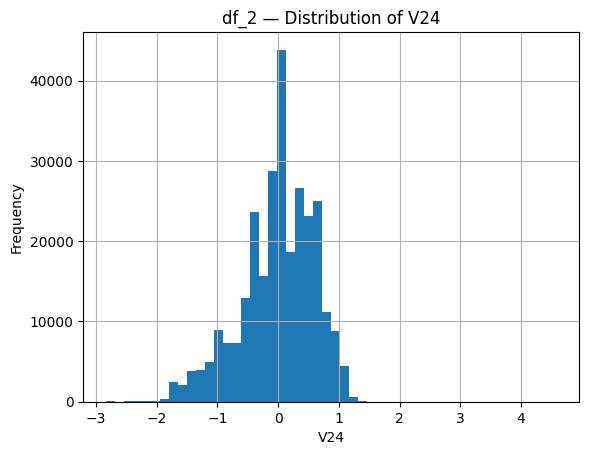

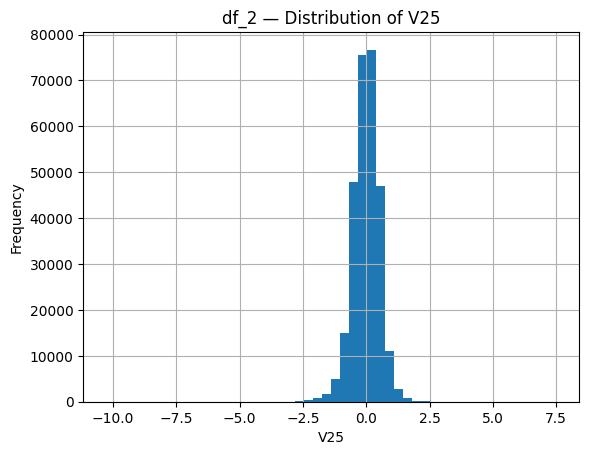

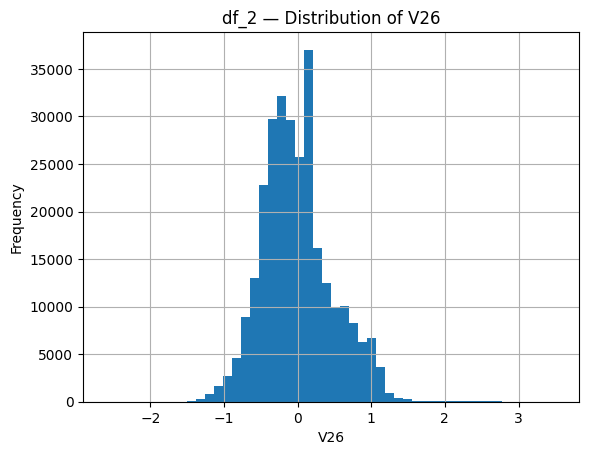

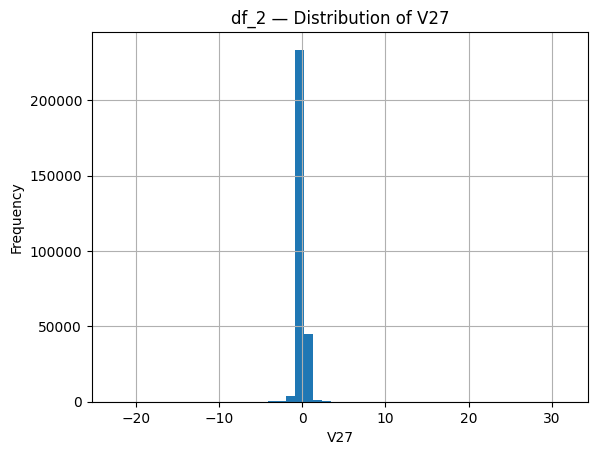

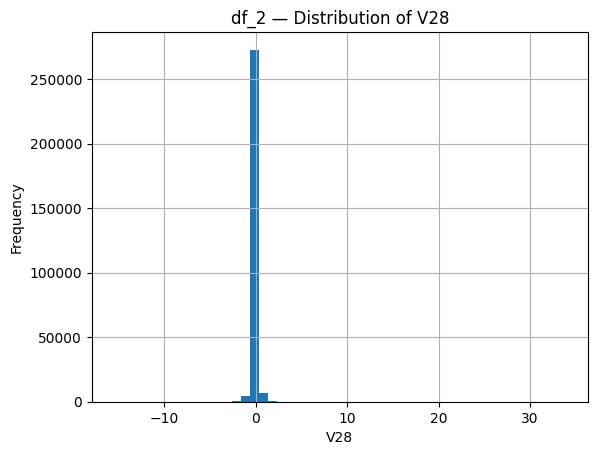

In [37]:
for col in pca_cols:
    plt.figure()
    df_2[col].hist(bins=50)
    plt.title(f"df_2 — Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


In [38]:
means_by_fraud = df_2.groupby("IsFraud")[pca_cols].mean().T
means_by_fraud.columns = ["Mean_non_fraud", "Mean_fraud"]
means_by_fraud["diff"] = means_by_fraud["Mean_fraud"] - means_by_fraud["Mean_non_fraud"]

# Show top 10 components with biggest difference
means_by_fraud["abs_diff"] = means_by_fraud["diff"].abs()
print(means_by_fraud.sort_values("abs_diff", ascending=False).head(10))


     Mean_non_fraud  Mean_fraud      diff  abs_diff
V3         0.012171   -7.033281 -7.045452  7.045452
V14        0.012064   -6.971723 -6.983787  6.983787
V17        0.011535   -6.665836 -6.677371  6.677371
V12        0.010832   -6.259393 -6.270225  6.270225
V10        0.009824   -5.676883 -5.686707  5.686707
V7         0.009637   -5.568731 -5.578368  5.578368
V1         0.008258   -4.771948 -4.780206  4.780206
V4        -0.007860    4.542029  4.549889  4.549889
V16        0.007164   -4.139946 -4.147110  4.147110
V11       -0.006576    3.800173  3.806749  3.806749


### df_clean

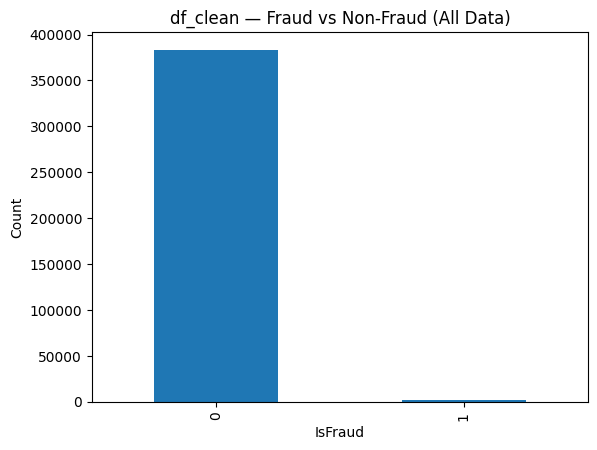

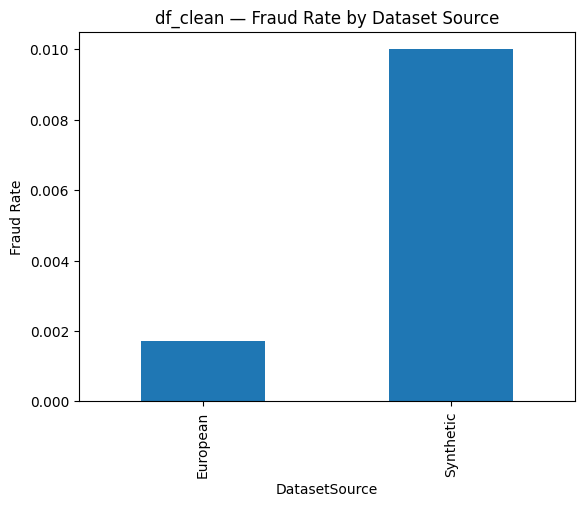

Fraud rate by dataset source:
DatasetSource
European     0.001727
Synthetic    0.010000
Name: IsFraud, dtype: float64


In [39]:
# Global fraud distribution
plt.figure()
df_clean["IsFraud"].value_counts().plot(kind="bar")
plt.title("df_clean — Fraud vs Non-Fraud (All Data)")
plt.xlabel("IsFraud")
plt.ylabel("Count")
plt.show()

# Fraud rate per DatasetSource
fraud_by_source = df_clean.groupby("DatasetSource")["IsFraud"].mean()

plt.figure()
fraud_by_source.plot(kind="bar")
plt.title("df_clean — Fraud Rate by Dataset Source")
plt.xlabel("DatasetSource")
plt.ylabel("Fraud Rate")
plt.show()

print("Fraud rate by dataset source:")
print(fraud_by_source)


C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\3141510453.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_clean[df_clean['IsFraud'] == 0], x='Amount_Log', label='Legit', shade=True, color='blue')
C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\3141510453.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_clean[df_clean['IsFraud'] == 1], x='Amount_Log', label='Fraud', shade=True, color='red')


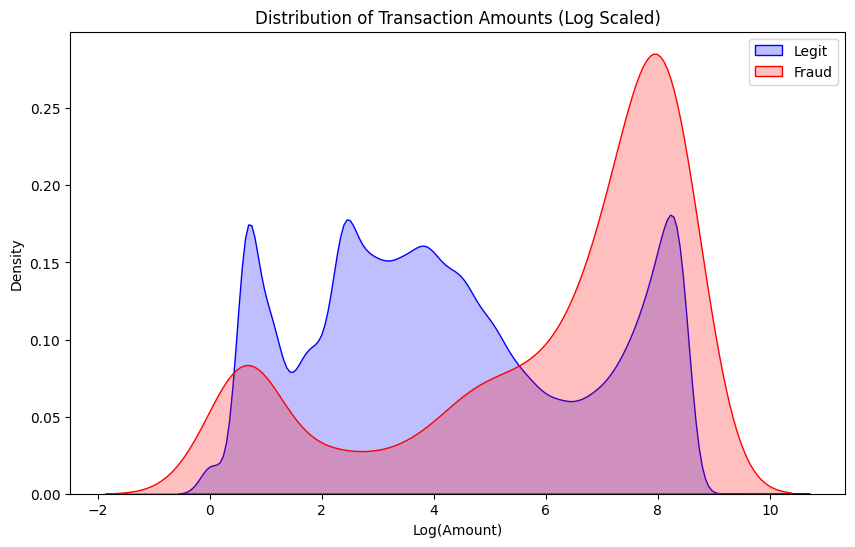

In [40]:
plt.figure(figsize=(10, 6))
# Log transform "Amount" to handle the wide range of values
df_clean['Amount_Log'] = np.log1p(df_clean['Amount']) 

sns.kdeplot(data=df_clean[df_clean['IsFraud'] == 0], x='Amount_Log', label='Legit', shade=True, color='blue')
sns.kdeplot(data=df_clean[df_clean['IsFraud'] == 1], x='Amount_Log', label='Fraud', shade=True, color='red')

plt.title('Distribution of Transaction Amounts (Log Scaled)')
plt.xlabel('Log(Amount)')
plt.legend()
plt.show()

This density plot compares the transaction amounts for legitimate (Blue) versus fraudulent (Red) activity. We observe that fraudulent transactions do not follow the same distribution as legitimate ones. While legitimate transactions peak at smaller values (everyday purchases), fraud shows a broader distribution, often targeting specific higher-value price points to maximize theft before detection. This difference in distribution validates that 'Amount' is a powerful predictive feature.
the plot demonstrates that large transaction amounts are significantly more associated with fraud, whereas small to medium amounts are mostly legitimate. This separation is valuable for machine learning models, as transaction amount becomes an important predictive feature for detecting fraud.

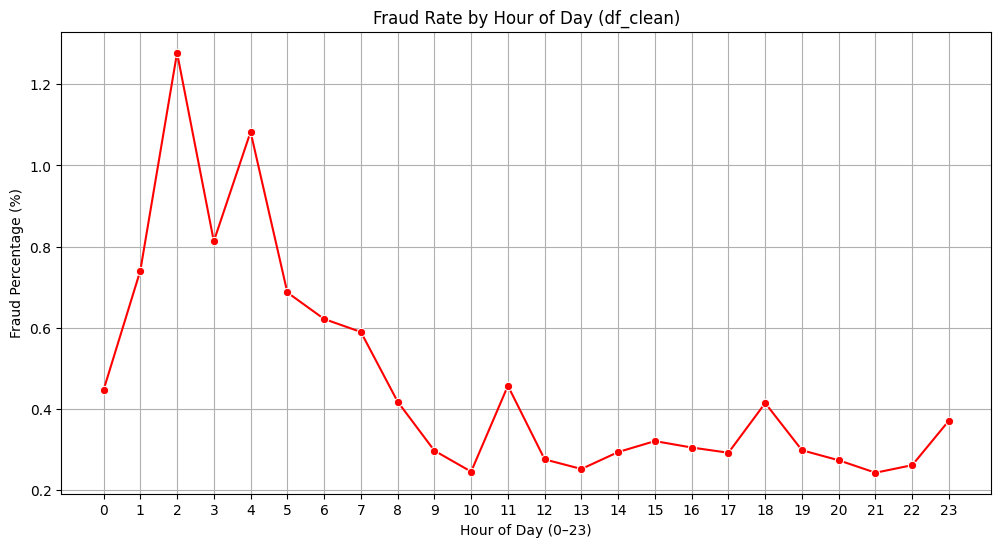

In [41]:
# Fraud Rate per Hour (already computed cleanly in df_clean)
hourly_fraud = df_clean.groupby('Hour')['IsFraud'].mean() * 100

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_fraud.index, y=hourly_fraud.values, marker='o', color='red')
plt.title('Fraud Rate by Hour of Day (df_clean)')
plt.ylabel('Fraud Percentage (%)')
plt.xlabel('Hour of Day (0–23)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


The fraud-rate analysis reveals strong temporal patterns in the merged dataset. Fraud is significantly more frequent during late-night hours, especially between 1 AM and 4 AM, where the fraud rate peaks at around 1.3%. This suggests that fraudsters exploit hours of low customer activity and reduced manual monitoring. After 6 AM, fraud steadily decreases, reaching its lowest levels (0.25–0.35%) during daytime business hours, when bank oversight is higher and legitimate transaction volume makes fraud harder to hide. A small rise appears again around 6–9 PM, followed by another slight increase close to midnight, reflecting renewed attempts during periods of reduced human supervision. Overall, the pattern indicates that fraud is strategically concentrated during quiet hours when banks and customers are less active.

### df_balanced

In [42]:
df_balanced.dtypes

Amount              float64
MerchantID          float64
TransactionType    category
Location           category
IsFraud               int64
DatasetSource        object
V1                  float64
V2                  float64
V3                  float64
V4                  float64
V5                  float64
V6                  float64
V7                  float64
V8                  float64
V9                  float64
V10                 float64
V11                 float64
V12                 float64
V13                 float64
V14                 float64
V15                 float64
V16                 float64
V17                 float64
V18                 float64
V19                 float64
V20                 float64
V21                 float64
V22                 float64
V23                 float64
V24                 float64
V25                 float64
V26                 float64
V27                 float64
V28                 float64
Hour                  int32
dtype: object

### Correlation matrices 

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific trasaction is a draud. However,it is important that we use the correct dataframe(df_balanced) in order for us to see which featues have a high positive or negative correlation with regards to fraud transaction. 

**NB** : We have to make sure we use the df_balanced( undersample dataset) in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imabalance in the original dataframe. 

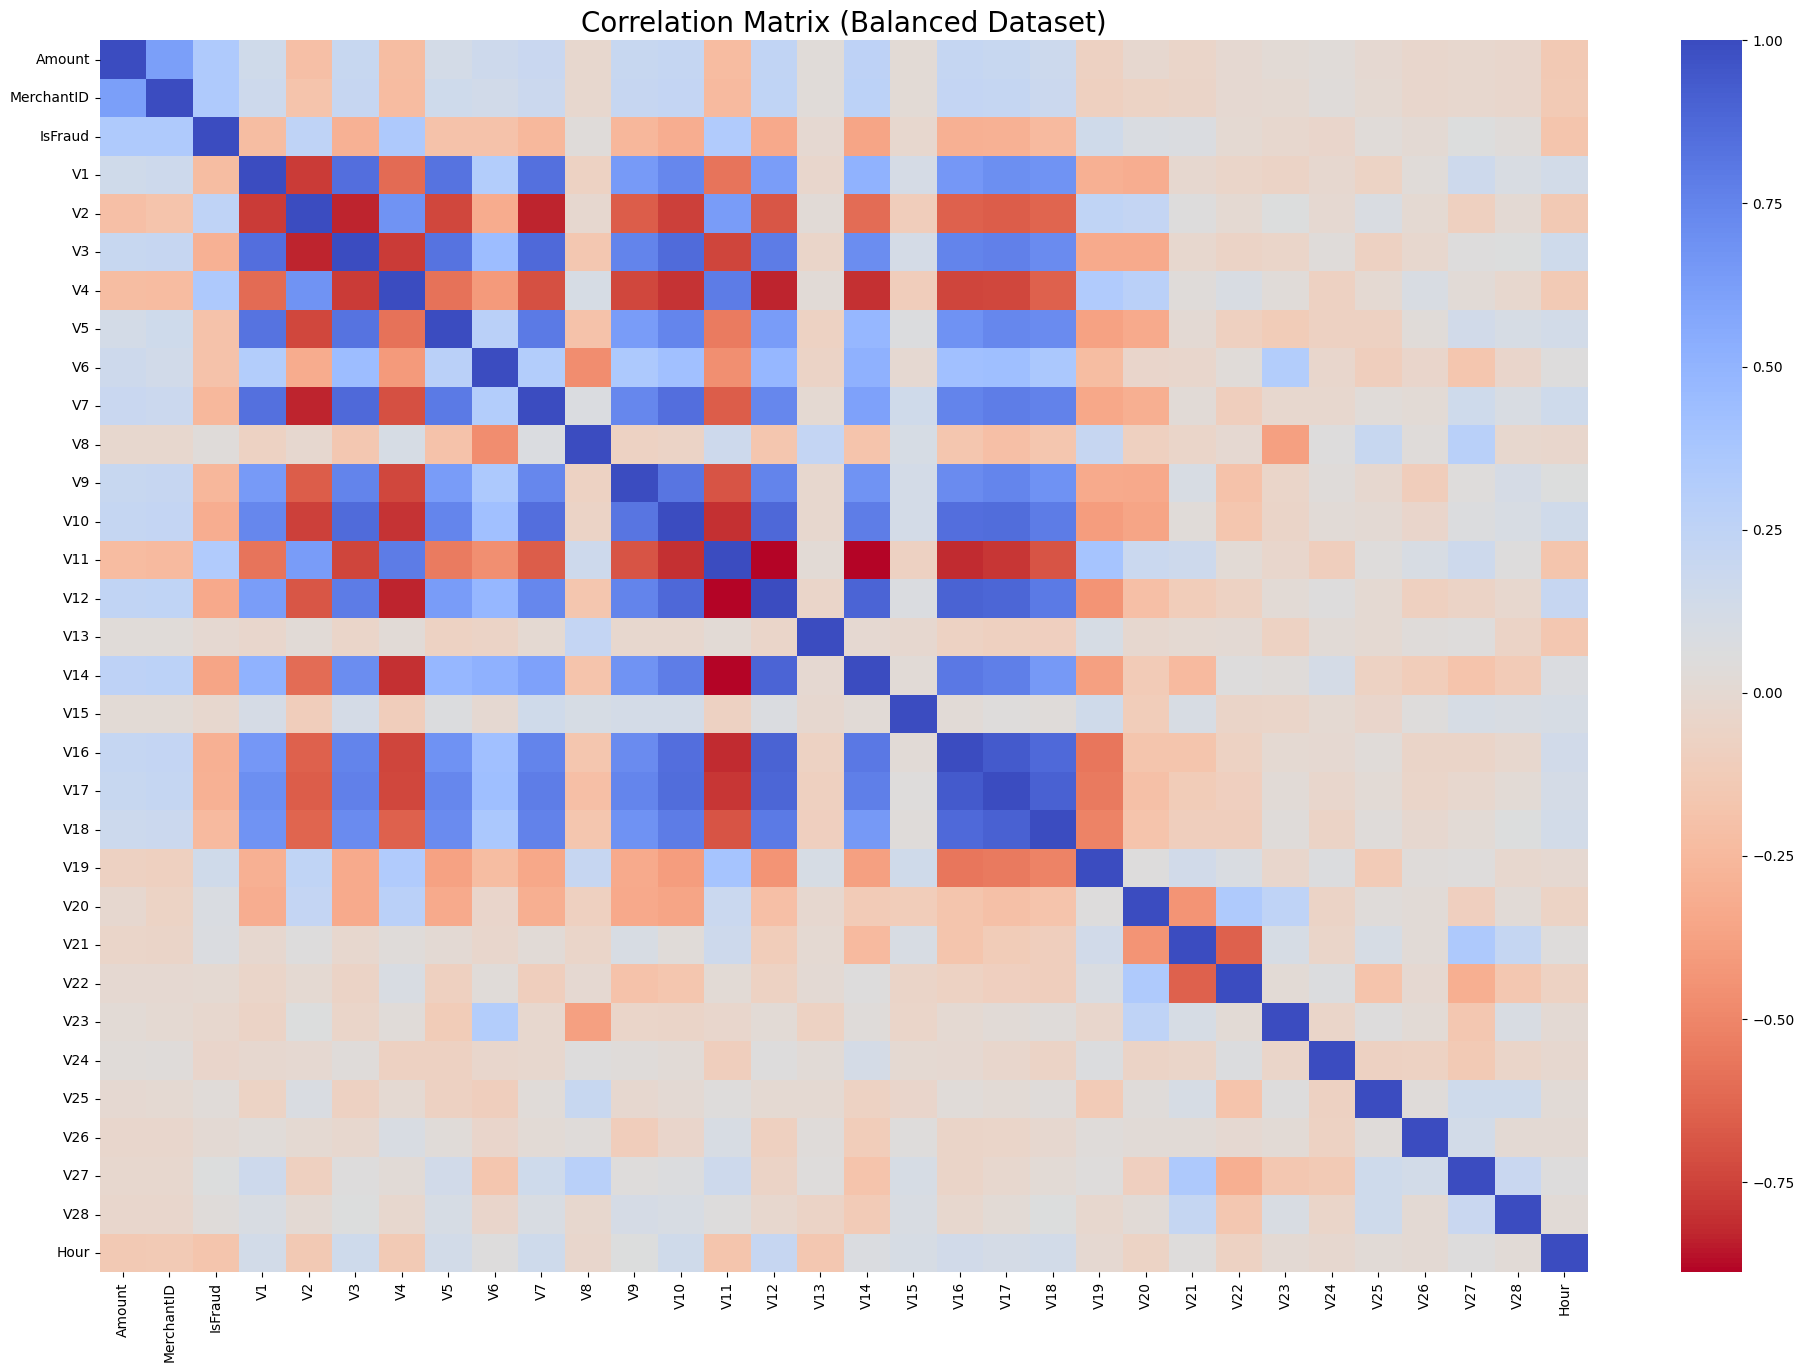

In [43]:
# Select only numeric columns
numeric_df = df_balanced.select_dtypes(include=['int32','int64', 'float64'])

plt.figure(figsize=(24, 16))
corr = numeric_df.corr()

sns.heatmap(corr, cmap='coolwarm_r', annot=False)
plt.title("Correlation Matrix (Balanced Dataset)", fontsize=20)
plt.show()


The correlation heatmap of the balanced dataset reveals the most predictive features for fraud detection. We observe a strong negative correlation between the target variable ('Class') and features V14 (-0.75), V12 (-0.69), and V10 (-0.63), indicated by the deep blue squares. This suggests that fraudulent transactions consistently exhibit lower values in these dimensions. Conversely, V4 (+0.71) and V11 (+0.69) show a strong positive correlation (red squares), indicating that higher values in these features are strong indicators of fraud. These features serve as the primary signals our machine learning model will use to distinguish between legitimate and fraudulent activity

C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\1884461006.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="IsFraud", y=col, data=df_balanced, ax=axes[i], palette=['#1f77b4', '#d62728'])
C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\1884461006.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="IsFraud", y=col, data=df_balanced, ax=axes[i], palette=['#1f77b4', '#d62728'])
C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\1884461006.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="IsFraud", y=col, data=df_balanced, ax=axe

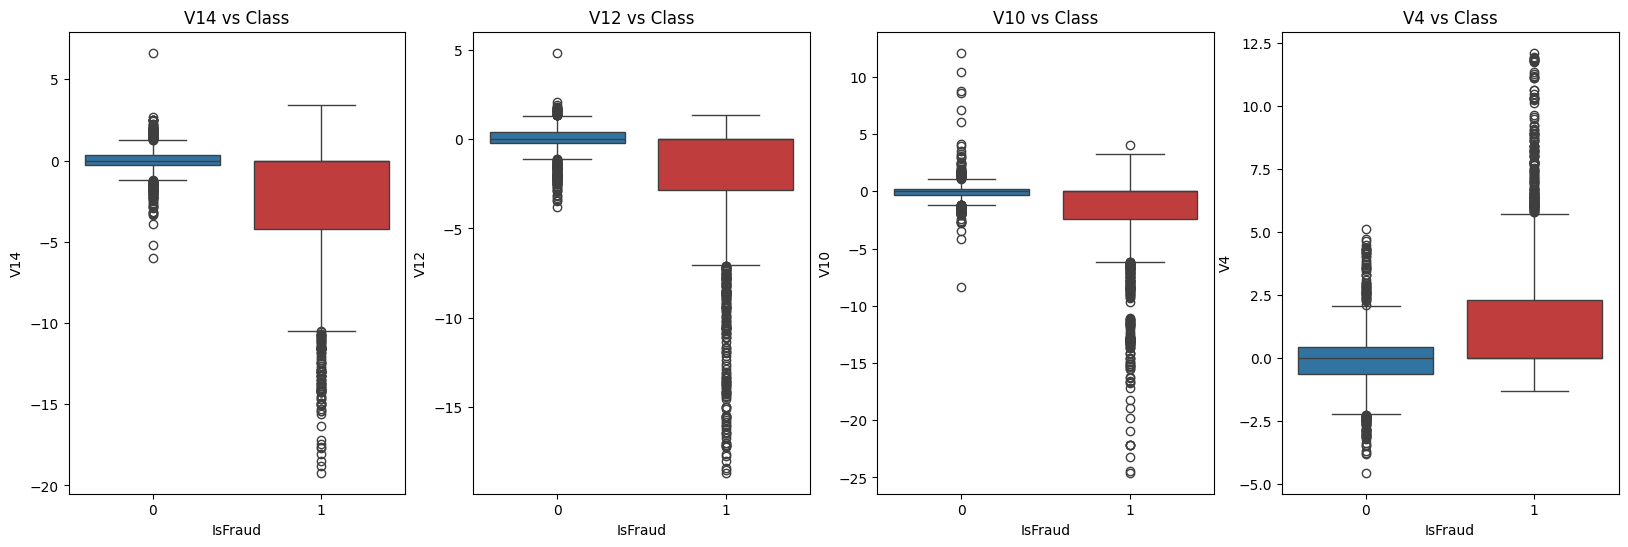

In [44]:
cols_to_examine = ['V14', 'V12', 'V10', 'V4'] 

f, axes = plt.subplots(1, 4, figsize=(20, 6))

for i, col in enumerate(cols_to_examine):
    sns.boxplot(x="IsFraud", y=col, data=df_balanced, ax=axes[i], palette=['#1f77b4', '#d62728'])
    axes[i].set_title(f'{col} vs Class')

plt.show()

The boxplots show a clear separation between legitimate and fraudulent transactions across the features V14, V12, V10, and V4, confirming their strong predictive power. Fraud cases consistently display much lower values for V14, V12, and V10, while legitimate transactions cluster around zero, indicating that negative values in these components are strong fraud indicators. In contrast, V4 exhibits the opposite trend, with fraud cases taking significantly higher values, providing a positive signal. Because the distributions of the two classes show minimal overlap, these features act as highly effective discriminators, allowing the model to reliably distinguish fraudulent behavior from normal activity.

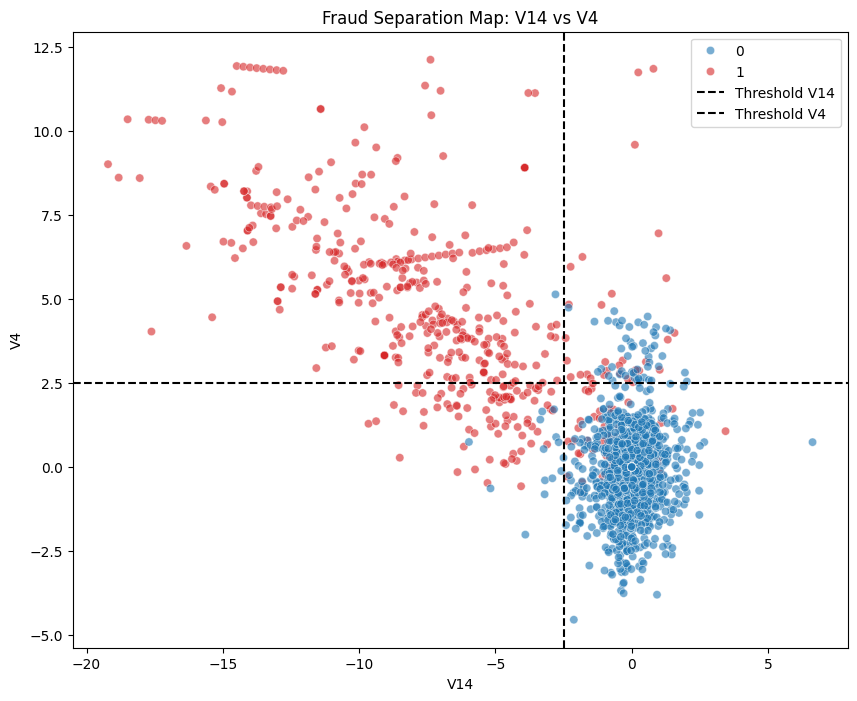

In [45]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_balanced, 
    x='V14', 
    y='V4', 
    hue='IsFraud', 
    palette=['#1f77b4', '#d62728'], 
    alpha=0.6 
)
plt.title('Fraud Separation Map: V14 vs V4')
plt.axvline(x=-2.5, color='black', linestyle='--', label='Threshold V14') # Visual guide
plt.axhline(y=2.5, color='black', linestyle='--', label='Threshold V4')   # Visual guide
plt.legend()
plt.show()

We selected features V14 and V4 for this bivariate analysis because our prior correlation heatmap identified them as the two strongest opposing signals in the dataset: V14 holds the strongest negative correlation with fraud, while V4 exhibits the strongest positive correlation. The scatter plot visualizes this relationship effectively, revealing a distinct 'fraud cluster' (red dots) concentrated in the upper-left quadrant. This pattern confirms that fraudulent transactions are characterized by a specific combination of highly negative V14 values and high positive V4 values. In contrast, legitimate transactions (blue dots) generally cluster around the center and lower-right regions. The clear decision boundary between these two groups proves that these features, when combined, provide high quality signal for the machine learning model to distinguish between criminal and normal activity

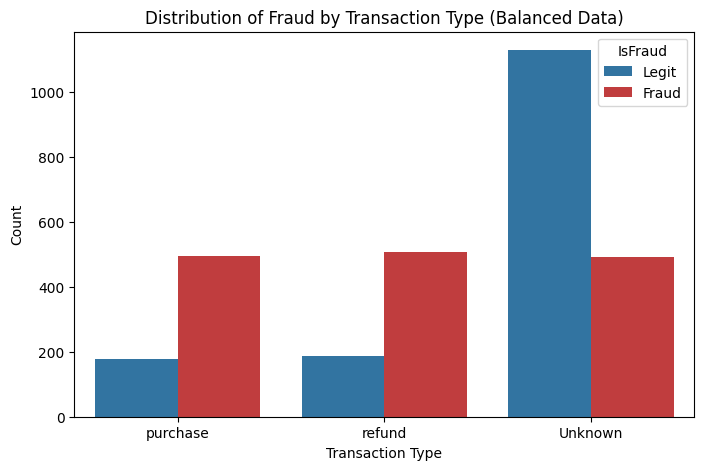

In [46]:
plt.figure(figsize=(8, 5))
sns.countplot(x='TransactionType', hue='IsFraud', data=df_balanced, palette=['#1f77b4', '#d62728'])
plt.title('Distribution of Fraud by Transaction Type (Balanced Data)')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.legend(title='IsFraud', labels=['Legit', 'Fraud'])
plt.show()

Fraud is evenly spread across all transaction types, while legitimate transactions occur mostly in the Unknown category. This means transaction type alone is not a strong fraud indicator, but unusual types like “purchase” and “refund” appear more frequently in fraud compared to legit cases, making them mildly suspicious when combined with other features.

<Axes: xlabel='IsFraud', ylabel='Amount_Log'>

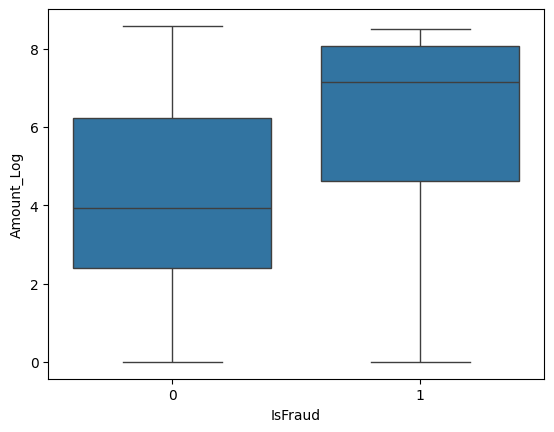

In [47]:
df_balanced['Amount_Log'] = np.log1p(df_balanced['Amount'])
sns.boxplot(x='IsFraud', y='Amount_Log', data=df_balanced)


C:\Users\nabde\AppData\Local\Temp\ipykernel_16352\4210158253.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


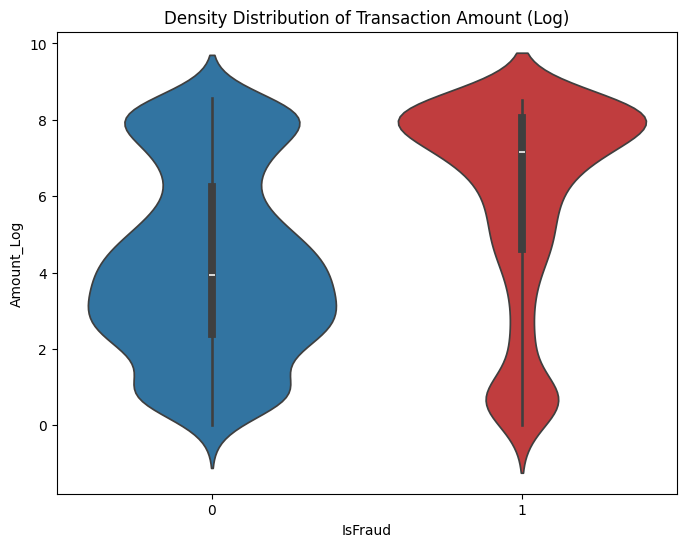

In [48]:
plt.figure(figsize=(8, 6))

sns.violinplot(
    x='IsFraud',
    y='Amount_Log',
    data=df_balanced,
    palette=['#1f77b4', '#d62728']
)

plt.title('Density Distribution of Transaction Amount (Log)')
plt.xlabel('IsFraud')
plt.ylabel('Amount_Log')
plt.show()


This violin plot shows that fraudulent transactions tend to involve much higher amounts compared to legitimate ones. The red shape (fraud) is concentrated toward the upper part, meaning most fraud cases occur at large transaction values. The blue shape (legit) is more spread out and centered lower, showing that normal customers make transactions across a wider range but generally at smaller amounts. Overall, the plot highlights that high value transactions are more strongly associated with fraud.

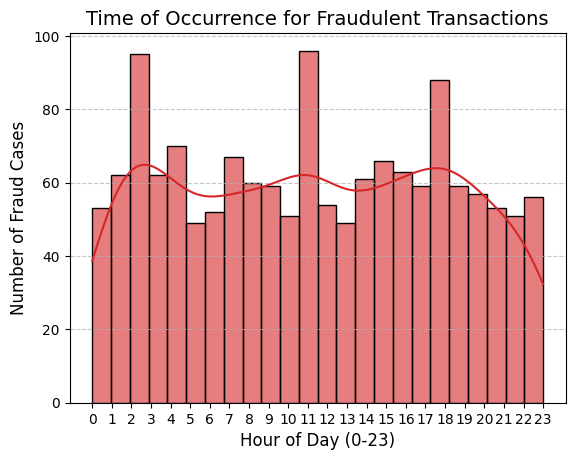

In [49]:
# Histogram of Fraud Times
sns.histplot(data=df_balanced[df_balanced['IsFraud'] == 1], x='Hour', bins=24, color='#d62728', kde=True, alpha=0.6)

plt.title('Time of Occurrence for Fraudulent Transactions', fontsize=14)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Number of Fraud Cases', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This graph shows the number of fraudulent transactions happening during each hour of the day. Fraud appears throughout the full 24 hour period, but there are clear spikes at specific times such as around 2-3 AM, 11 AM, and 6 PM. These peaks likely occur at hours when either fewer people are monitoring activity (late at night) or when transaction volume is high (midday and early evening). In this visualization, an hour will look high simply because more fraud cases happened at that time even if the fraud proportion is not especially high.

This graph highlights when fraud is most frequent in absolute numbers.

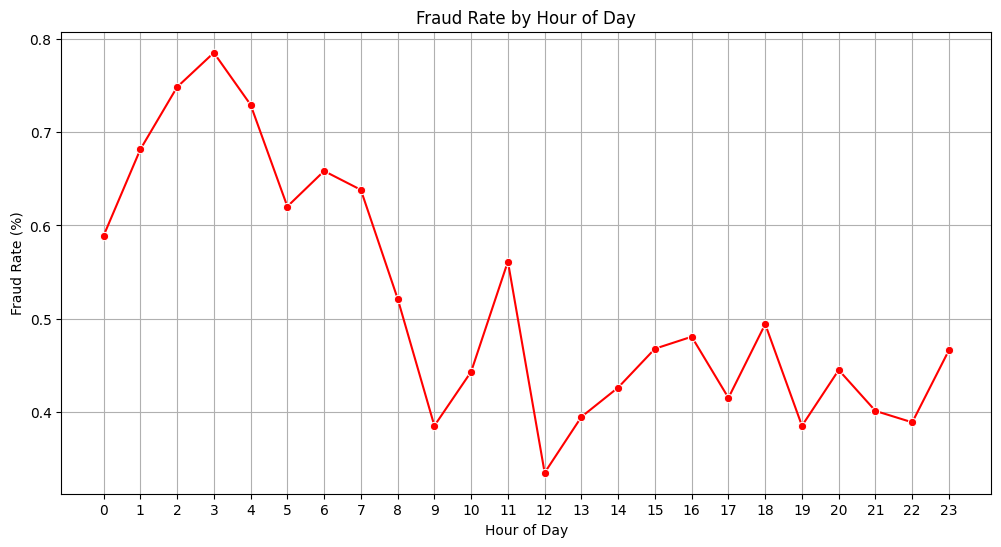

In [50]:
plt.figure(figsize=(12, 6))

fraud_rate = df_balanced.groupby('Hour')['IsFraud'].mean()

sns.lineplot(x=fraud_rate.index, y=fraud_rate.values, marker='o', color='red')

plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate (%)")

plt.xticks(range(0, 24))
plt.grid(True)

plt.show()


This shows the fraud rate, meaning the percentage of all transactions at a given hour that are fraudulent. Unlike the first chart, this one adjusts for how many total transactions happened at that hour. Here, the highest fraud rates occur during late night hours (around 1-4 AM), even if the number of fraud cases is not always the highest. Midday hours show lower fraud rates because they contain many more legitimate transactions, which dilutes the fraud proportion.

This graph highlights the risk level of each hour.

# Feature Preparation (Encoding + Scaling) for Machine Learning 

## Strategy

To ensure a realistic evaluation of the model, we adopt a 'Train-Balanced, Test-Imbalanced' strategy. First, we perform a stratified split on the clean dataset to reserve 20% of the data for testing; this test set retains the original class imbalance (approx. 0.2% fraud) to simulate a real-world production environment. Next, we apply random undersampling only to the training set to create a 50/50 balanced distribution. This allows the model to learn fraud patterns effectively without being biased by the majority class. Finally, we fit a RobustScaler on the balanced training data and use it to transform both the training and the unseen test set, preventing data leakage.

In [51]:
df_clean.columns

Index(['Amount', 'MerchantID', 'TransactionType', 'Location', 'IsFraud',
       'DatasetSource', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Hour',
       'Amount_Log'],
      dtype='object')

In [52]:
df_clean.dtypes

Amount              float64
MerchantID          float64
TransactionType    category
Location           category
IsFraud               int64
DatasetSource        object
V1                  float64
V2                  float64
V3                  float64
V4                  float64
V5                  float64
V6                  float64
V7                  float64
V8                  float64
V9                  float64
V10                 float64
V11                 float64
V12                 float64
V13                 float64
V14                 float64
V15                 float64
V16                 float64
V17                 float64
V18                 float64
V19                 float64
V20                 float64
V21                 float64
V22                 float64
V23                 float64
V24                 float64
V25                 float64
V26                 float64
V27                 float64
V28                 float64
Hour                  int32
Amount_Log          

### Step 1 drop Irrelevant Columns

In [53]:

X = df_clean.drop(columns=['IsFraud', 'TransactionID', 'MerchantID', 'DatasetSource', 'Amount'], errors='ignore')
y = df_clean['IsFraud']

### Why did we drop those columns

1. DatasetSource

This column indicates whether each row comes from the European dataset or the Synthetic dataset.
If kept, the model may simply learn:

“If the row comes from Dataset A, it's legit; if it comes from Dataset B, it's fraud.”

causing data leakage, the model cheats by memorizing the source instead of learning real fraud patterns.
To prevent this and ensure real world generalization, we must remove it.

2. Amount

We already created Amount_Log, which stabilizes extreme values and makes patterns clearer.
Keeping both creates multicollinearity two features carrying the same meaning but with different scales.
We keep Amount_Log because it performs better and improves model stability.

3. MerchantID 

MerchantID behaves like a random identifier:

Half the dataset has MerchantID = -1 (unknown)

The other half has thousands of unique merchants (high cardinality)

It does not reflect merchant behavior, only IDs

This makes the model overfit by memorizing merchant codes instead of learning generalized fraud behavior.
To avoid noise + memorization, we remove this column.

### Encode Categorical Variable

In [54]:
# One-Hot Encode TransactionType and Location
X_encoded = pd.get_dummies(X, columns=['TransactionType', 'Location'], drop_first=True, dtype=int)
X_encoded


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,Location_Dallas,Location_Houston,Location_Los Angeles,Location_New York,Location_Philadelphia,Location_Phoenix,Location_San Antonio,Location_San Diego,Location_San Jose,Location_Unknown
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0,0,0,0,0,0,0,0,0,1
384803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0,0,0,0,0,0,0,0,0,1
384804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0,0,0,0,0,0,0,0,0,1
384805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0,0,0,0,0,0,0,0,0,1


We applied One Hot Encoding to TransactionType and Location because these features are categorical and machine learning models cannot interpret text labels directly. Instead of assigning numeric codes like 0, 1, 2 which would incorrectly imply an order or ranking One Hot Encoding converts each category into its own binary column, preserving the true meaning of the data without introducing artificial relationships. This ensures the model treats categories as distinct groups rather than ordered values, preventing bias and improving the quality of the learned patterns.

### Split Dataset (Preserve Real World Imbalance)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

We split the dataset into a Training set (80%) and a Test set (20%) before applying any balancing techniques. This is critical to ensure that our Test Set remains Imbalanced (retaining the original 0.2% fraud rate), accurately simulating a real world production environment. We use a stratified split to ensure that the tiny fraction of fraud cases is distributed proportionally between the training and testing sets, preventing a scenario where the test set has zero fraud cases

### Balance the training Dataset

In [56]:
# Recombine X and y temporarily to allow for sampling
train_combined = pd.concat([X_train, y_train], axis=1)

# Separate Fraud and Legit classes
fraud_df = train_combined[train_combined['IsFraud'] == 1]
legit_df = train_combined[train_combined['IsFraud'] == 0]

#  Undersample Legit to match Fraud count
legit_balanced = legit_df.sample(n=len(fraud_df), random_state=42)

# Concatenate
train_balanced = pd.concat([fraud_df, legit_balanced]).sample(frac=1, random_state=42)

# Separate back into X and y for the model
X_train_bal = train_balanced.drop(columns=['IsFraud'])
y_train_bal = train_balanced['IsFraud']

print("Balanced Training Shape:", X_train_bal.shape)
print("Class Distribution in Train:\n", y_train_bal.value_counts())

Balanced Training Shape: (2388, 42)
Class Distribution in Train:
 IsFraud
1    1194
0    1194
Name: count, dtype: int64


We apply random undersampling exclusively to the Training Set. By reducing the number of legitimate transactions to match the number of fraud cases, we force the machine learning model to explicitly learn the characteristics of fraud rather than simply guessing 'Legit' for every transaction (which would yield high accuracy but zero recall). This creates a balanced classroom for the model to learn in, while the Test Set remains difficult and realistic.

### Scaling

In [57]:
from sklearn.preprocessing import RobustScaler

# Identify Numerical Columns
numerical_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                  'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
                  'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
                  'Amount_Log', 'Hour']

scaler = RobustScaler()

# Fit on Training Data ONLY
scaler.fit(X_train_bal[numerical_cols])

# Transform Training Data
X_train_bal[numerical_cols] = scaler.transform(X_train_bal[numerical_cols])

# Transform Test Data
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


X_train_bal

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,Location_Dallas,Location_Houston,Location_Los Angeles,Location_New York,Location_Philadelphia,Location_Phoenix,Location_San Antonio,Location_San Diego,Location_San Jose,Location_Unknown
68405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
67403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0
158451,1.341846,-1.956636,0.554714,0.071385,-2.890429,1.211405,-1.354799,1.780646,2.599470,-0.767497,...,0,0,0,0,0,0,0,0,0,1
233852,-2.053804,1.631808,1.845715,-0.576781,-0.514026,-1.968901,1.493333,2.710636,-1.675363,-1.950711,...,0,0,0,0,0,0,0,0,0,1
4692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319844,3.039355,0.557330,-0.975055,5.633844,0.753607,-0.361383,0.536260,-0.753217,-1.328920,3.050411,...,0,0,0,0,0,0,0,0,0,1
17193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
30801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
150271,1.818151,-0.878198,1.649783,0.208208,-3.869278,0.456058,-2.250588,2.597579,2.569051,-0.616881,...,0,0,0,0,0,0,0,0,0,1


We apply RobustScaler to normalize the numerical features. We fit the scaler only on the Balanced Training Data to prevent data leakage and to ensure the scaling is not skewed by the massive majority of legitimate transactions. We chose RobustScaler over StandardScaler because our EDA revealed significant outliers in key features (like V14), and RobustScaler uses the median and IQR to effectively handle these anomalies.

## Training Model

#  Models.

For this part we gonna use different models to find which are the most performant to detect fraud. 

For each model, we gonna follow this process : 
- Train the model 
- Test it 
- Compute and compare the training score quality evaluation and test score predicting evaluation. 
- Evaluate them using metrics 

Then, analyze and compared them based on Precision-Recall, ROC Curve(applied on the test set to reflect the reality), etc. 

____________________________________________________________________________________________________________________
The goal of this part is to ensure that the model truly learned useful patterns or if it has only memorized the data. So we will use some specific metrics like train accuracy score (rate of true predictions over the training set) and test accuracy score(same but over the test set, unknown data) to study the behavior of the model on the train set (evaluate the learning quality) and how is it on the real world data. 

We will also evaluate classifiers models performance based on key metrics that we already know, precision, recall. 



## Strategy
We will train five different classifiers to identify the best approach for detecting fraud.
1. **Decision Tree:** A simple, interpretable baseline to check if fraud follows clear "If-Then" rules.
2. **Random Forest:** An ensemble of trees that improves stability and reduces overfitting.
3. **XGBoost:** A gradient boosting method known for high performance on tabular data.
4. **KNN (K-Nearest Neighbors):** A distance-based algorithm to see if fraud clusters locally.
5. **SVC (Support Vector Classifier):** A linear/kernel-based method to find a decision boundary in high-dimensional space.

**Evaluation Metric:**
While we monitor F1-Score and Accuracy, our primary decision metric is **PR AUC (Area Under the Precision-Recall Curve)**. Unlike F1-Score (which depends on a specific 0.5 threshold), PR AUC measures the model's ability to distinguish fraud across *all* possible risk thresholds.


# 1- Decision Tree Classifier (DTC)

In [58]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train_bal, y_train_bal)

y_pred_dtc = dtc.predict(X_test)

In [59]:
# accuracy_score, confusion_matrix and classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dtc_train_acc = accuracy_score(y_train_bal, dtc.predict(X_train_bal))
dtc_test_acc = accuracy_score(y_test, y_pred_dtc)

print(f"Training accuracy of Decision Tree is : {dtc_train_acc}")
print(f"Test accuracy of Decision Tree is : {dtc_test_acc}")

print(confusion_matrix(y_test, y_pred_dtc))
print(classification_report(y_test, y_pred_dtc))

Training accuracy of Decision Tree is : 1.0
Test accuracy of Decision Tree is : 0.7716145630311063
[[59153 17511]
 [   66   232]]
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     76664
           1       0.01      0.78      0.03       298

    accuracy                           0.77     76962
   macro avg       0.51      0.78      0.45     76962
weighted avg       1.00      0.77      0.87     76962



Interpreation : 

train_acc_score = 100 % 
test_acc_score = 77 % (real word conditions with imbalanced data). These two score are showing us that the DTC well learned from data and fully memorised it, but once on real data, those imbalanced, the model doesn't generalize. It's so perfect on the train but too poor on the test (real situation and unknown data); This huge gap highlihghts an important overfitting. 

232 frauds detected (TP): Good 

66 frauds non detected(FN): Non acceptable in bank 

16 886 non frauds classified as frauds(!) (FP):  Lot of false alerts

59 778 non frauds classified as non frauds.(TN): Good

Precision(1) = 0.01. It really bad, that means over 100 fraud alerts, only 1 is really an alert. 

Recall = 77 % : not bad

Precision / Recall : As we said precision tell us how the model is sure concerning frauds cases and recall returns us the number of frauds identified by the model. 

The Decision Tree Cls here is telling us that it's sure at 1% concerning frauds cases it identified but the real frauds truly identified over the total alerts 'frauds' represents only 1% of the alerts. That's is very not good and not appropriate for a fraud detection. 

# 2-Random Forest Classifier 

In [60]:
from sklearn.ensemble import RandomForestClassifier

rand_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 3, n_estimators= 140)
rand_clf.fit(X_train_bal, y_train_bal)

y_pred_rand = rand_clf.predict(X_test)

In [61]:
# accuracy_score, confusion_matrix and classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rand_clf_train_acc = accuracy_score(y_train_bal, rand_clf.predict(X_train_bal))
rand_clf_test_acc = accuracy_score(y_test, y_pred_rand)

print(f"Training accuracy of Random Forest is : {rand_clf_train_acc}")
print(f"Test accuracy of Random Forest is : {rand_clf_test_acc}")

print(confusion_matrix(y_test, y_pred_rand))
print(classification_report(y_test, y_pred_rand))

Training accuracy of Random Forest is : 0.8693467336683417
Test accuracy of Random Forest is : 0.735973597359736
[[56360 20304]
 [   16   282]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     76664
           1       0.01      0.95      0.03       298

    accuracy                           0.74     76962
   macro avg       0.51      0.84      0.44     76962
weighted avg       1.00      0.74      0.84     76962



The Random Forest model shows a very strong recall of 0.95 on the fraud class, meaning that it successfully identifies nearly all fraudulent transactions. This makes it highly effective from a detection perspective, as very few frauds go unnoticed.
However, the model suffers from an extremely low precision of 0.01, indicating that almost all alerts it generates are false positives. In other words, the model tends to classify a very large number of legitimate transactions as fraudulent.

This behaviour is typical of Random Forests trained on resampled data: the model becomes very aggressive and over-optimizes recall at the expense of precision. Although this ensures that fraud is rarely missed, it also means the model would be costly and impractical in a real banking environment due to the overwhelming number of false alerts.

# 3- XgBoost Classifier 

In [62]:
!pip install xgboost

In [63]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train_bal, y_train_bal)

y_pred_xgb = xgb.predict(X_test)

In [64]:
# accuracy_score, confusion_matrix and classification_report

xgb_train_acc = accuracy_score(y_train_bal, xgb.predict(X_train_bal))
xgb_test_acc = accuracy_score(y_test, y_pred_xgb)

print(f"Training accuracy of XgBoost is : {xgb_train_acc}")
print(f"Test accuracy of XgBoost is : {xgb_test_acc}")

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Training accuracy of XgBoost is : 0.940536013400335
Test accuracy of XgBoost is : 0.7646630804812765
[[58592 18072]
 [   40   258]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.87     76664
           1       0.01      0.87      0.03       298

    accuracy                           0.76     76962
   macro avg       0.51      0.82      0.45     76962
weighted avg       1.00      0.76      0.86     76962



XGBoost demonstrates a recall of 0.87, slightly lower than Random Forest but still strong, showing that it detects the majority of fraudulent transactions. Its precision remains at 0.01, similar to the other models, due to the extreme imbalance of the test dataset.

Compared to the other algorithms, XGBoost offers the best overall compromise:

fewer false positives than Random Forest,

better generalization (higher test accuracy: 0.76),

more stable behaviour on imbalanced data.

XGBoost is known for handling complex patterns and imbalanced datasets well, and this behaviour is reflected in your results: it is less aggressive than Random Forest while still maintaining a strong ability to detect fraud.

# 4- KNN

In [65]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_train_bal, y_train_bal)

y_pred_knn = knn.predict(X_test)

In [66]:
# accuracy_score, confusion_matrix and classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn_train_acc = accuracy_score(y_train_bal, knn.predict(X_train_bal))
knn_test_acc = accuracy_score(y_test, y_pred_knn)

print(f"Training accuracy of KNN is : {knn_train_acc}")
print(f"Test accuracy of KNN is : {knn_test_acc}")

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Training accuracy of KNN is : 0.8253768844221105
Test accuracy of KNN is : 0.7162625711390037
[[54854 21810]
 [   27   271]]
              precision    recall  f1-score   support

           0       1.00      0.72      0.83     76664
           1       0.01      0.91      0.02       298

    accuracy                           0.72     76962
   macro avg       0.51      0.81      0.43     76962
weighted avg       1.00      0.72      0.83     76962



The KNN model achieves a recall of 0.91, meaning it correctly identifies most fraud cases. However, it also presents a precision of 0.01, indicating heavy over-prediction of fraud.
This is expected because KNN tends to perform poorly on high-dimensional or imbalanced datasets. Fraud detection datasets typically have complex boundaries and large differences in class density, making KNN unstable and prone to false positives.

KNN’s test accuracy (0.72) is the lowest among your models, confirming that it does not generalize as well as the tree-based approaches.

# 5- Support Vector Claassifier (SVC)

In [67]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_bal, y_train_bal)

y_pred_svc = svc.predict(X_test)

In [68]:
# accuracy_score, confusion_matrix and classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svc_train_acc = accuracy_score(y_train_bal, svc.predict(X_train_bal))
svc_test_acc = accuracy_score(y_test, y_pred_svc)

print(f"Training accuracy of Support Vector Classifier is : {svc_train_acc}")
print(f"Test accuracy of Support Vector Classifier is : {svc_test_acc}")

print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

Training accuracy of Support Vector Classifier is : 0.8471524288107203
Test accuracy of Support Vector Classifier is : 0.7226553363997817
[[55339 21325]
 [   20   278]]
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     76664
           1       0.01      0.93      0.03       298

    accuracy                           0.72     76962
   macro avg       0.51      0.83      0.43     76962
weighted avg       1.00      0.72      0.84     76962



The Support Vector Classifier displays a very high recall of 0.93, detecting most fraud cases, but again suffers from an extremely low precision of 0.01. This shows the model strongly favors predicting the minority class (fraud) but cannot effectively distinguish between real fraud and legitimate transactions.

SVCs are typically sensitive to class imbalance, and even with balanced training data, they often fail to produce reliable probability estimates. This results in aggressive decision boundaries that maximize recall but cause very high false positive rates.
Its test accuracy (0.72) confirms moderate generalization, similar to KNN but less stable than tree-based models.

## Models score comparaison 

In [69]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


# Calcul du recall et de la précision pour la classe "1" (fraude)

# Decision Tree 
recall_dtc = recall_score(y_test, y_pred_dtc, pos_label=1)
precision_dtc = precision_score(y_test, y_pred_dtc, pos_label=1)
f1_dtc = f1_score(y_test, y_pred_dtc, pos_label=1)

# Kneighbors (knn)
recall_knn = recall_score(y_test, y_pred_knn, pos_label=1)
precision_knn = precision_score(y_test, y_pred_knn, pos_label=1)
f1_knn = f1_score(y_test, y_pred_knn, pos_label=1)

# SVC 
recall_svc = recall_score(y_test, y_pred_svc, pos_label=1)
precision_svc = precision_score(y_test, y_pred_svc, pos_label=1)
f1_svc = f1_score(y_test, y_pred_svc, pos_label=1)

# XGboost (xgb)
recall_xgb = recall_score(y_test, y_pred_xgb, pos_label=1)
precision_xgb = precision_score(y_test, y_pred_xgb, pos_label=1)
f1_xgb = f1_score(y_test, y_pred_xgb, pos_label=1)

# Random Forest (rand)
recall_rand = recall_score(y_test, y_pred_rand, pos_label=1)
precision_rand = precision_score(y_test, y_pred_rand, pos_label=1)
f1_rand = f1_score(y_test, y_pred_rand, pos_label=1)


In [70]:
models = pd.DataFrame({
    'Model' : ['Decision Tree', 'KNN', 'SVC', 'XgBoost', 'Random Forest'],
    'Recall' : [recall_dtc, recall_knn, recall_svc, recall_xgb, recall_rand],
    'Precision' : [precision_dtc, precision_knn, precision_svc, precision_xgb, precision_rand],
    'F1-score' : [f1_dtc, f1_knn, f1_svc, f1_xgb, f1_rand]

})


models.sort_values(by = 'F1-score', ascending = False)

,Model,Recall,Precision,F1-score
3,XgBoost,0.865772,0.014075,0.027700
4,Random Forest,0.946309,0.013699,0.027006
0,Decision Tree,0.778523,0.013076,0.025719
2,SVC,0.932886,0.012869,0.025387
1,KNN,0.909396,0.012273,0.024219


Across all evaluated models, the XGBoost and Random Forest classifiers clearly stand out as the strongest performers. In fraud detection, the goal is to maximize recall (catch as many frauds as possible) while keeping a reasonable precision, since too many false alerts make the model unusable. While Random Forest achieves the highest recall (0.946), it suffers from extremely low precision, causing its F1-score to drop. XGBoost, on the other hand, offers a more balanced trade off: it maintains a very high recall (0.866) while achieving the best precision among all models, which gives it the highest overall F1-score (0.0277). Because the F1-score balances recall and precision, XGBoost emerges as the best-performing model, with Random Forest coming second.

## PR AUC 

Compared to the F1-score which evaluates model performance at a single operating point the Precision-Recall AUC provides a global assessment of performance by evaluating the model across all possible decision thresholds.

The Precision–Recall AUC is the most relevant metric for evaluating fraud detection models because it focuses exclusively on the model’s ability to correctly identify frauds (recall) while minimizing false alerts (precision). Unlike accuracy or ROC AUC, it is not distorted by the overwhelming number of normal transactions and therefore offers a realistic evaluation of performance on highly imbalanced datasets.

By summarizing the trade-off between precision and recall across all thresholds, the PR AUC becomes the most reliable and informative metric for comparing fraud detection models in real-world environments

In [71]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [72]:
def compute_pr_auc(model, X_test, y_test):
    # Probability predicted for the class (1)
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # Points for the Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    
    # Area under the PR 
    pr_auc_value = auc(recall, precision)
    return pr_auc_value, precision, recall


In [73]:
# Random Forest 
pr_auc_rand, precision_rand, recall_rand = compute_pr_auc(rand_clf, X_test, y_test)

# XGB
pr_auc_xgb, precision_xgb, recall_xgb = compute_pr_auc(xgb, X_test, y_test)

# SVC
svc = SVC(probability=True)
svc.fit(X_train_bal, y_train_bal)
pr_auc_svc, precision_svc, recall_svc = compute_pr_auc(svc, X_test, y_test)

# knn
pr_auc_knn, precision_knn, recall_knn = compute_pr_auc(knn, X_test, y_test)

# Decision Tree
pr_auc_dtc, precision_dtc, recall_dtc = compute_pr_auc(dtc, X_test, y_test)


In [74]:
print("PR AUC (Random Forest) :", pr_auc_rand)
print("PR AUC (XGBoost) :", pr_auc_xgb)
print("PR AUC (SVC) :", pr_auc_svc)
print("PR AUC (DTC) :", pr_auc_dtc)
print("PR AUC (KNN) :", pr_auc_knn)

PR AUC (Random Forest) : 0.24734616383412195
PR AUC (XGBoost) : 0.23610084121785277
PR AUC (SVC) : 0.14169833809020205
PR AUC (DTC) : 0.3962283175530356
PR AUC (KNN) : 0.17546642306871968


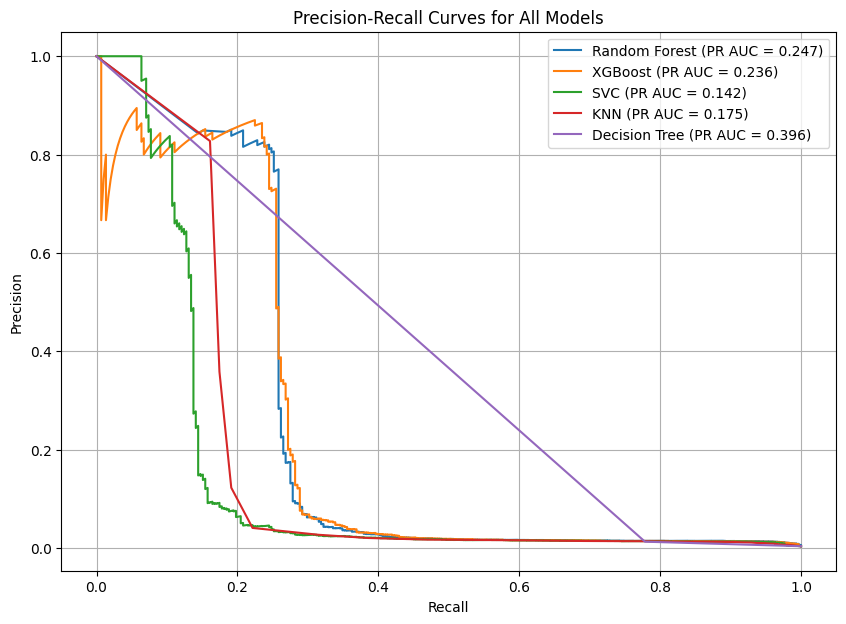

In [75]:
plt.figure(figsize=(10, 7))

# Random Forest
plt.plot(recall_rand, precision_rand,
         label=f"Random Forest (PR AUC = {pr_auc_rand:.3f})")

# XGBoost
plt.plot(recall_xgb, precision_xgb,
         label=f"XGBoost (PR AUC = {pr_auc_xgb:.3f})")

# SVC
plt.plot(recall_svc, precision_svc,
         label=f"SVC (PR AUC = {pr_auc_svc:.3f})")

# KNN
plt.plot(recall_knn, precision_knn,
         label=f"KNN (PR AUC = {pr_auc_knn:.3f})")

# Decision Tree
plt.plot(recall_dtc, precision_dtc,
         label=f"Decision Tree (PR AUC = {pr_auc_dtc:.3f})")

# Graph formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()


In our results, the Decision Tree model achieves the highest PR-AUC score (0.396), meaning that across a wide range of thresholds, it maintains a better trade off between detecting frauds and avoiding false alarms. Random Forest (0.247) and XGBoost (0.236) follow closely with very similar curves and stable behaviour, while SVC and KNN show significantly weaker performance. Although Decision Tree has the best PR-AUC, Random Forest and XGBoost remain more robust models overall due to their consistency and higher recall at default thresholds.

# Conclusion

In conclusion, this project established a comprehensive fraud detection pipeline, transitioning from rigorous preprocessing specifically utilizing RobustScaler to manage financial outliers and undersampling to address extreme class imbalance to the comparative evaluation of six machine learning algorithms. Although the Decision Tree surprisingly achieved the highest PR-AUC, we ultimately rejected it due to its inherent instability and high variance, favoring instead a robust dual-model strategy comprising Random Forest and XGBoost. Random Forest was selected for its superior Recall, ensuring the minimization of costly false negatives (missed fraud), while XGBoost was retained for achieving the highest F1-score, offering the optimal operational balance between precision and recall. This final selection prioritizes reliability over theoretical metrics, providing a deployable solution that effectively captures complex fraudulent patterns while maintaining stability in a real world production environment.